In [1]:
import os, shutil

import xarray as xr
import dask.dataframe as dd

#from rechunker import rechunk
# need version 0.3.3, see: https://github.com/pangeo-data/rechunker/issues/92

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
import pandas as pd
import numpy as np

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3
                 )
#
client = Client(cluster)

In [4]:
def load_llczarr(out_dir):
    # output archives
    llc_zarr = os.path.join(out_dir, "llc.zarr")
    ds = xr.open_zarr(llc_zarr)
    ds['zonal_velocity_var'] = (ds['zonal_velocity']-ds['zonal_velocity'].mean('time'))**2
    ds['meridional_velocity_var'] = (ds['meridional_velocity']-ds['meridional_velocity'].mean('time'))**2
    ds['KE'] = 0.5*(ds['zonal_velocity']**2+ds['meridional_velocity']**2)
    ds['MKE'] = 0.5*(ds['zonal_velocity'].mean('time')**2+ds['meridional_velocity'].mean('time')**2)
    ds['EKE'] = 0.5*(ds['zonal_velocity_var']+ds['meridional_velocity_var'])
    return ds

In [5]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
def plot_site(bbox,k,colmap='RdBu_r',figsize=(5,5)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, k, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    for a in ax:
        a.add_geometries(gdf_crs['geometry'],
                          crs=crs,
                          facecolor='grey', 
                          edgecolor='black',
                          alpha=0.5,
                         )

        a.gridlines(draw_labels=True)
    #    ax.coastlines(resolution='50m')
        a.set_extent(bbox)
    return fig, ax

In [16]:
def plot_KE(out_dir,bbox,sli,vmax):
    ds = load_llczarr(out_dir)
    KE = ds[['KE','lon','lat']].mean('time').compute()
    MKE = ds[['MKE','lon','lat','zonal_velocity','meridional_velocity']].mean('time').compute()
    EKE = ds[['EKE','lon','lat']].mean('time').compute()
    
    fig,axs = plot_site(bbox,2,figsize=(16,8))
    cs = axs[0].pcolormesh(MKE.lon,MKE.lat,MKE.MKE,
                           transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=0.025,vmin=0)
    #plt.colorbar(cs,ax=axs[0])
    axs[0].quiver(MKE.lon.values[::sli,::sli],MKE.lat.values[::sli,::sli],
                  MKE.zonal_velocity.values[::sli,::sli],MKE.meridional_velocity.values[::sli,::sli],
                  transform=ccrs.PlateCarree(),scale=3)
    axs[0].set_title(r'$MKE = \frac{1}{2}(\bar u^2+\bar v^2)$',fontsize=15)
    plt.colorbar(cs,ax=axs[0])
    fig.delaxes(axs[1])
    fig.tight_layout()
    fig,axs = plot_site(bbox,2,figsize=(20,10))

    cs = axs[0].pcolormesh(KE.lon,KE.lat,KE.KE,
                           transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=vmax,vmin=0)
    plt.colorbar(cs,ax=axs[0])
    #axs[0].quiver(ds_mean.lon.values[::sli,::sli],ds_mean.lat.values[::sli,::sli],
    #              ds_mean.zonal_velocity_var.values[::sli,::sli],ds_mean.meridional_velocity_var.values[::sli,::sli],
    #              transform=ccrs.PlateCarree(),scale=3)
    cs = axs[1].pcolormesh(EKE.lon,EKE.lat,EKE.EKE,
                           transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=vmax,vmin=0)
    plt.colorbar(cs,ax=axs[1])
    #axs[1].quiver(ds_mean.lon.values[::sli,::sli],ds_mean.lat.values[::sli,::sli],
    #              ds_mean.zonal_velocity_var.values[::sli,::sli],ds_mean.meridional_velocity_var.values[::sli,::sli],
    #              transform=ccrs.PlateCarree(),scale=3)
    fig.tight_layout()
    axs[0].set_title(r'$\overline{KE} = \overline{\frac{1}{2}(u^2+v^2)}$',fontsize=15)
    axs[1].set_title(r'$\overline{EKE} = \overline{\frac{1}{2}((u-\bar u)^2+(v-\bar v)^2)}$',fontsize=15)
    return MKE

In [9]:
tracks = ut.load_swot_tracks()

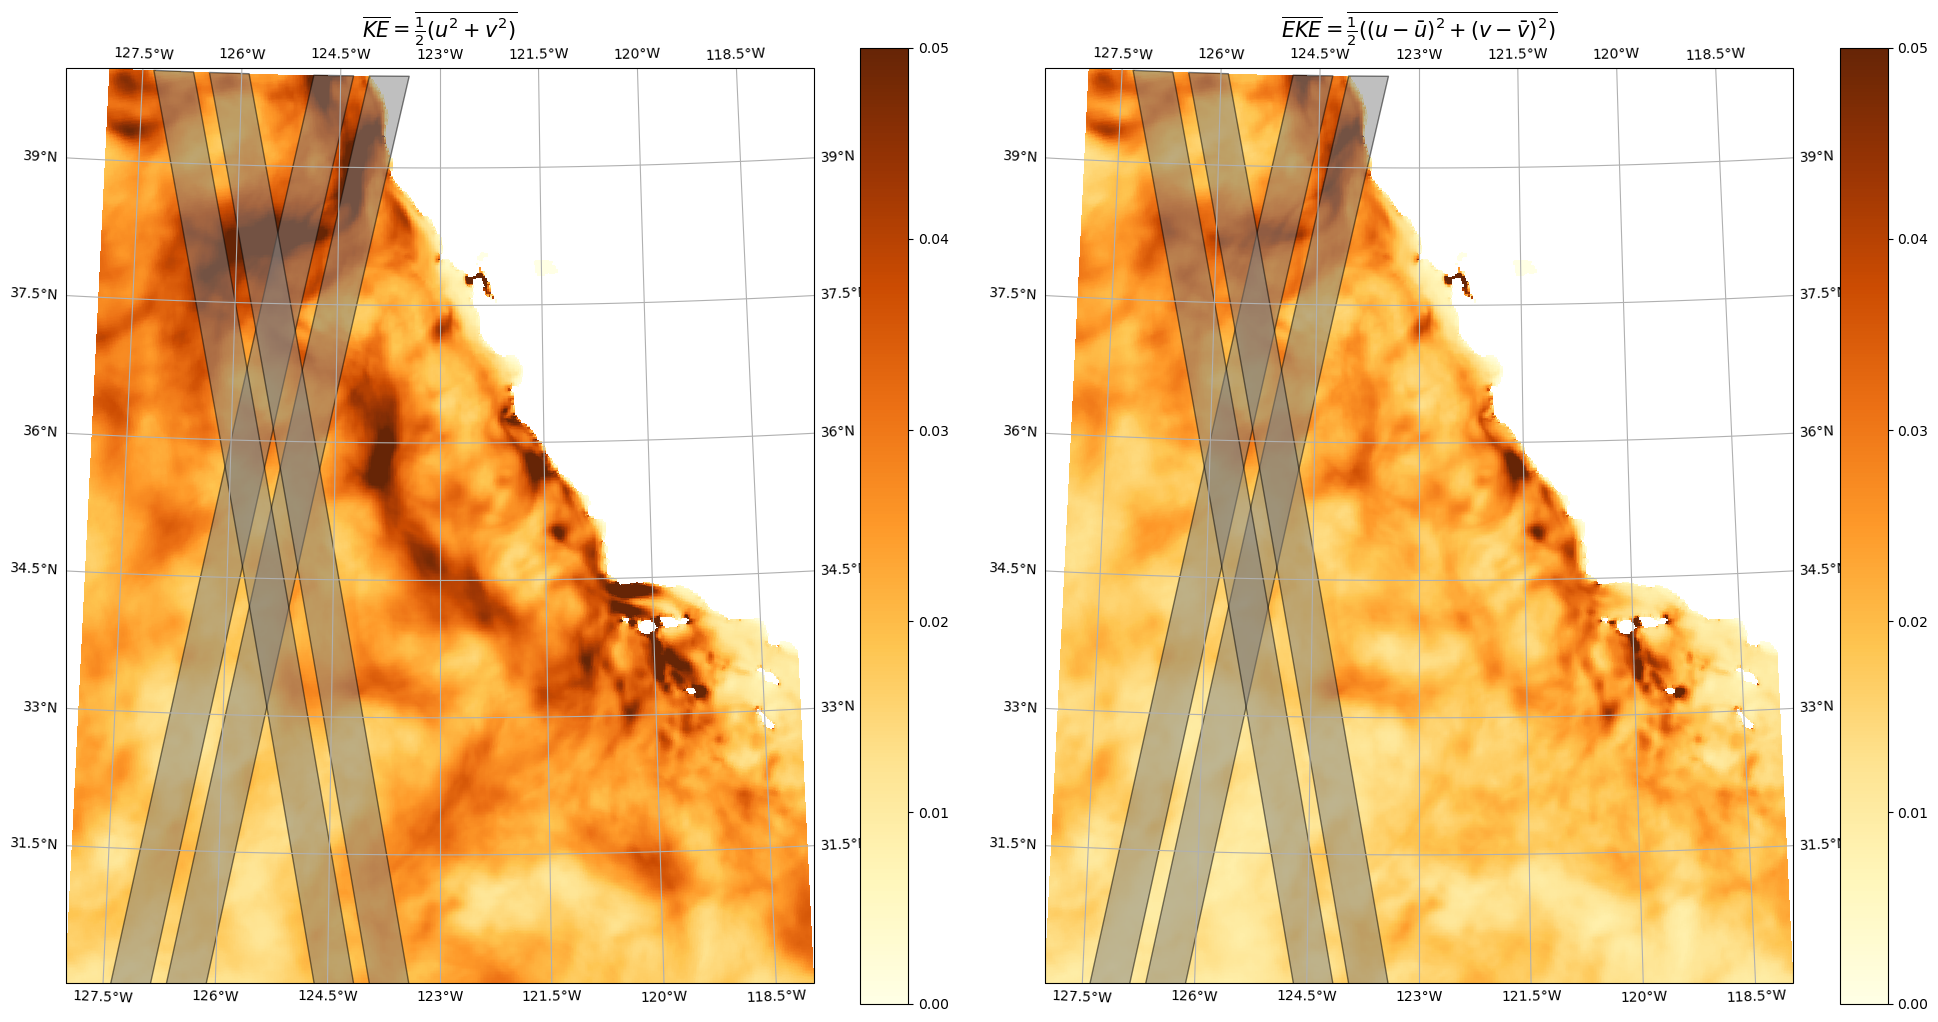

In [18]:
out_dir_cal = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_california")
bbox = [-128, -118, 30, 40] # california
sli = 15
MKE_cal = plot_KE(out_dir_cal,bbox,sli,0.05)

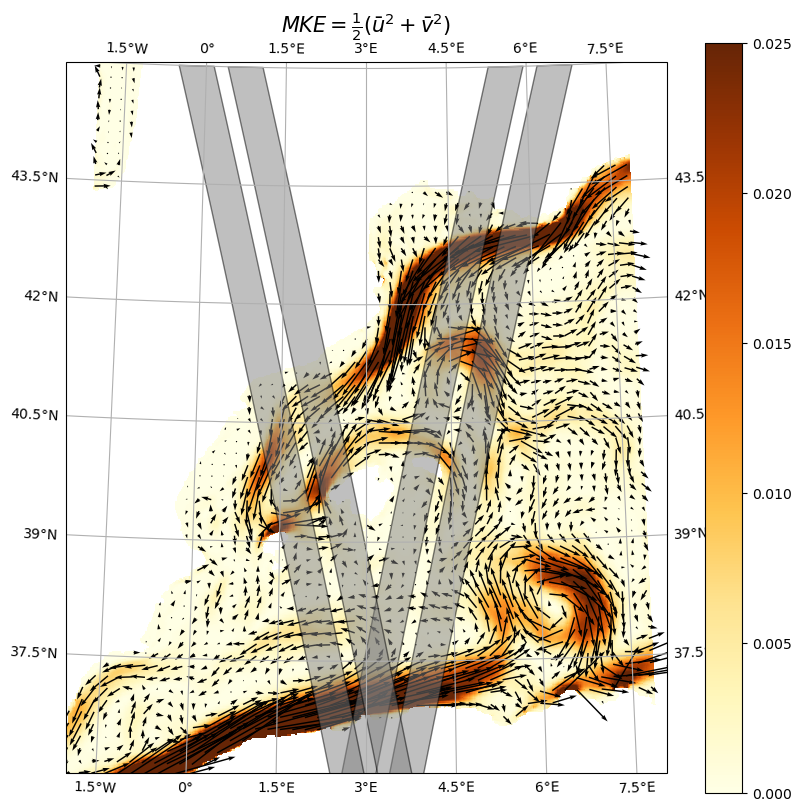

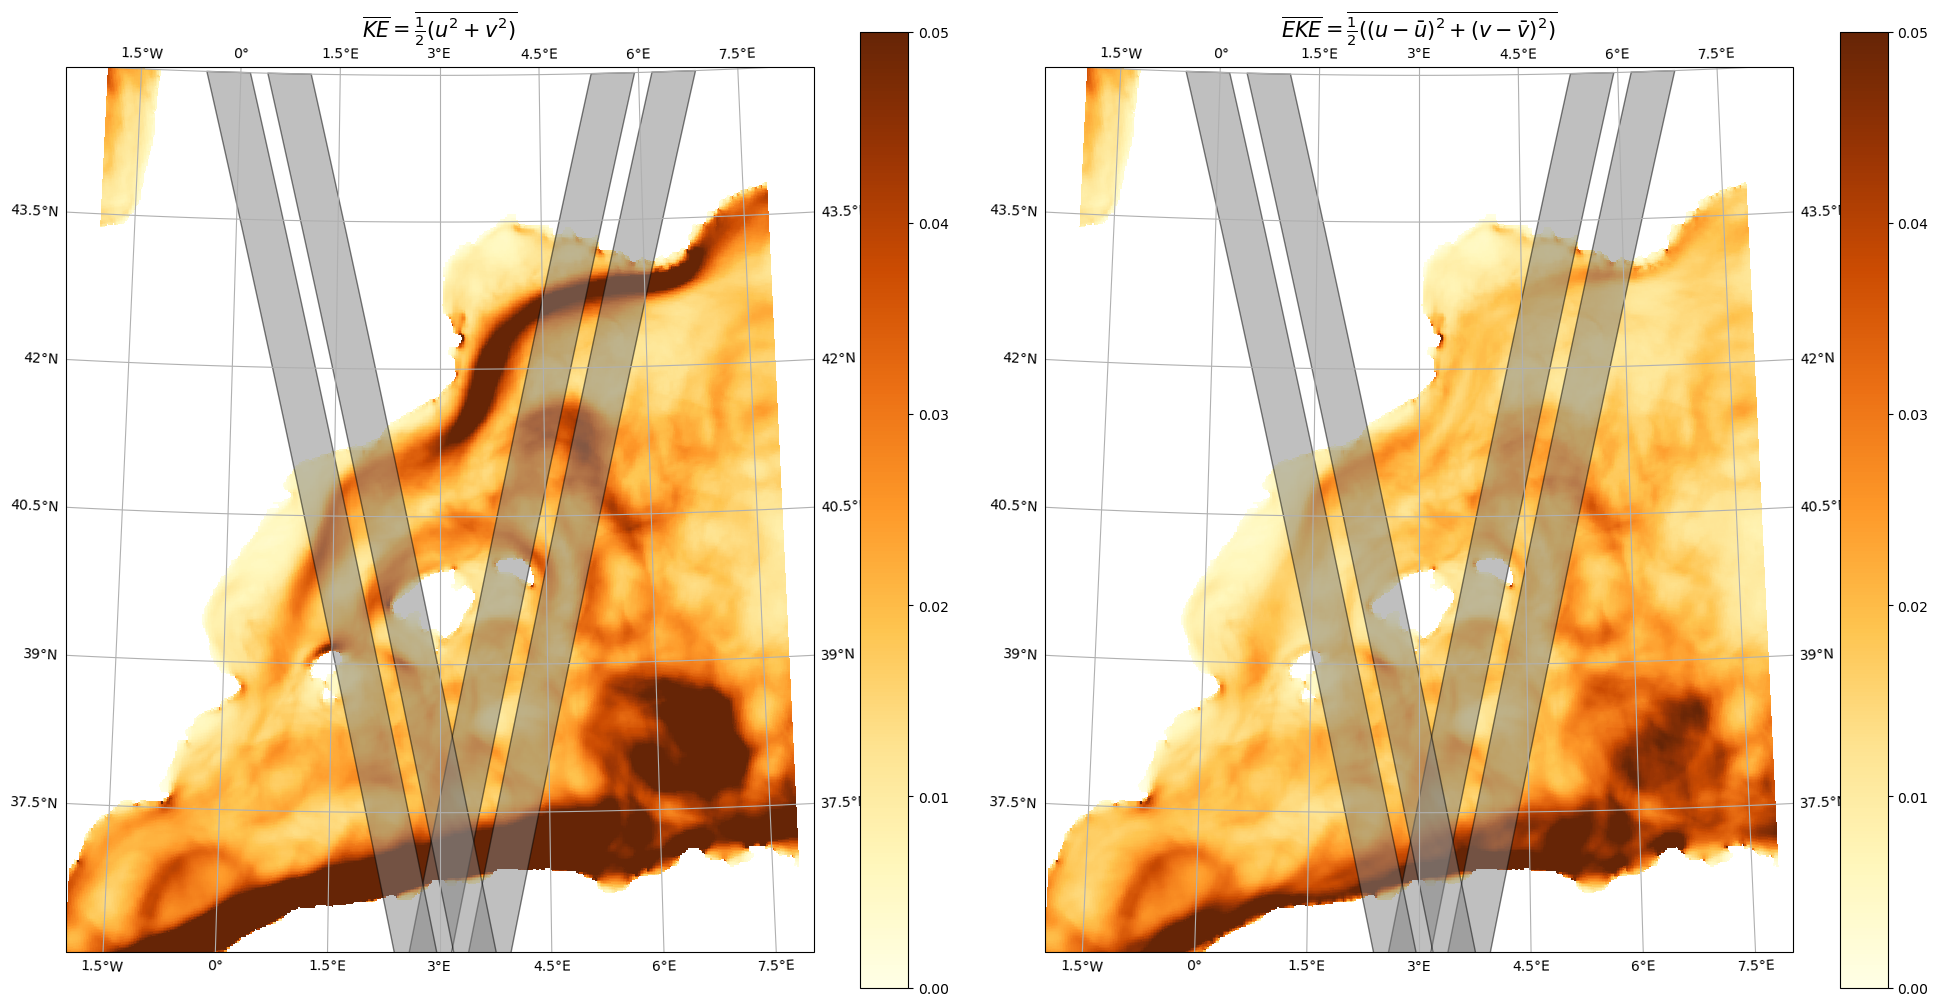

In [14]:
out_dir_med = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_mediterranean")
bbox = [-2, 8, 36, 45] # mediterranean sea
sli = 10
MKE_med = plot_KE(out_dir_med,bbox,sli,0.05)

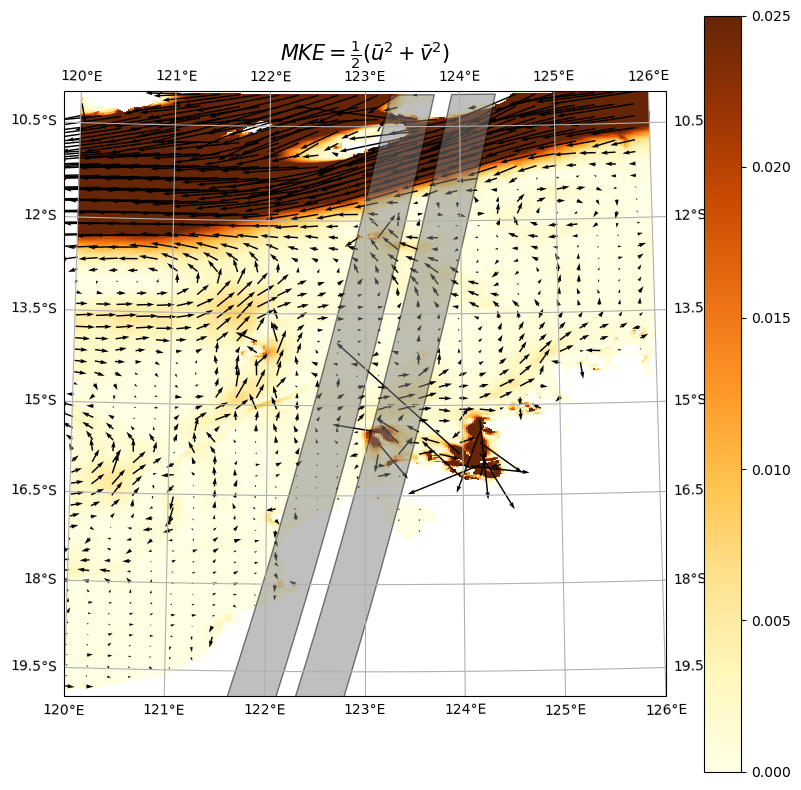

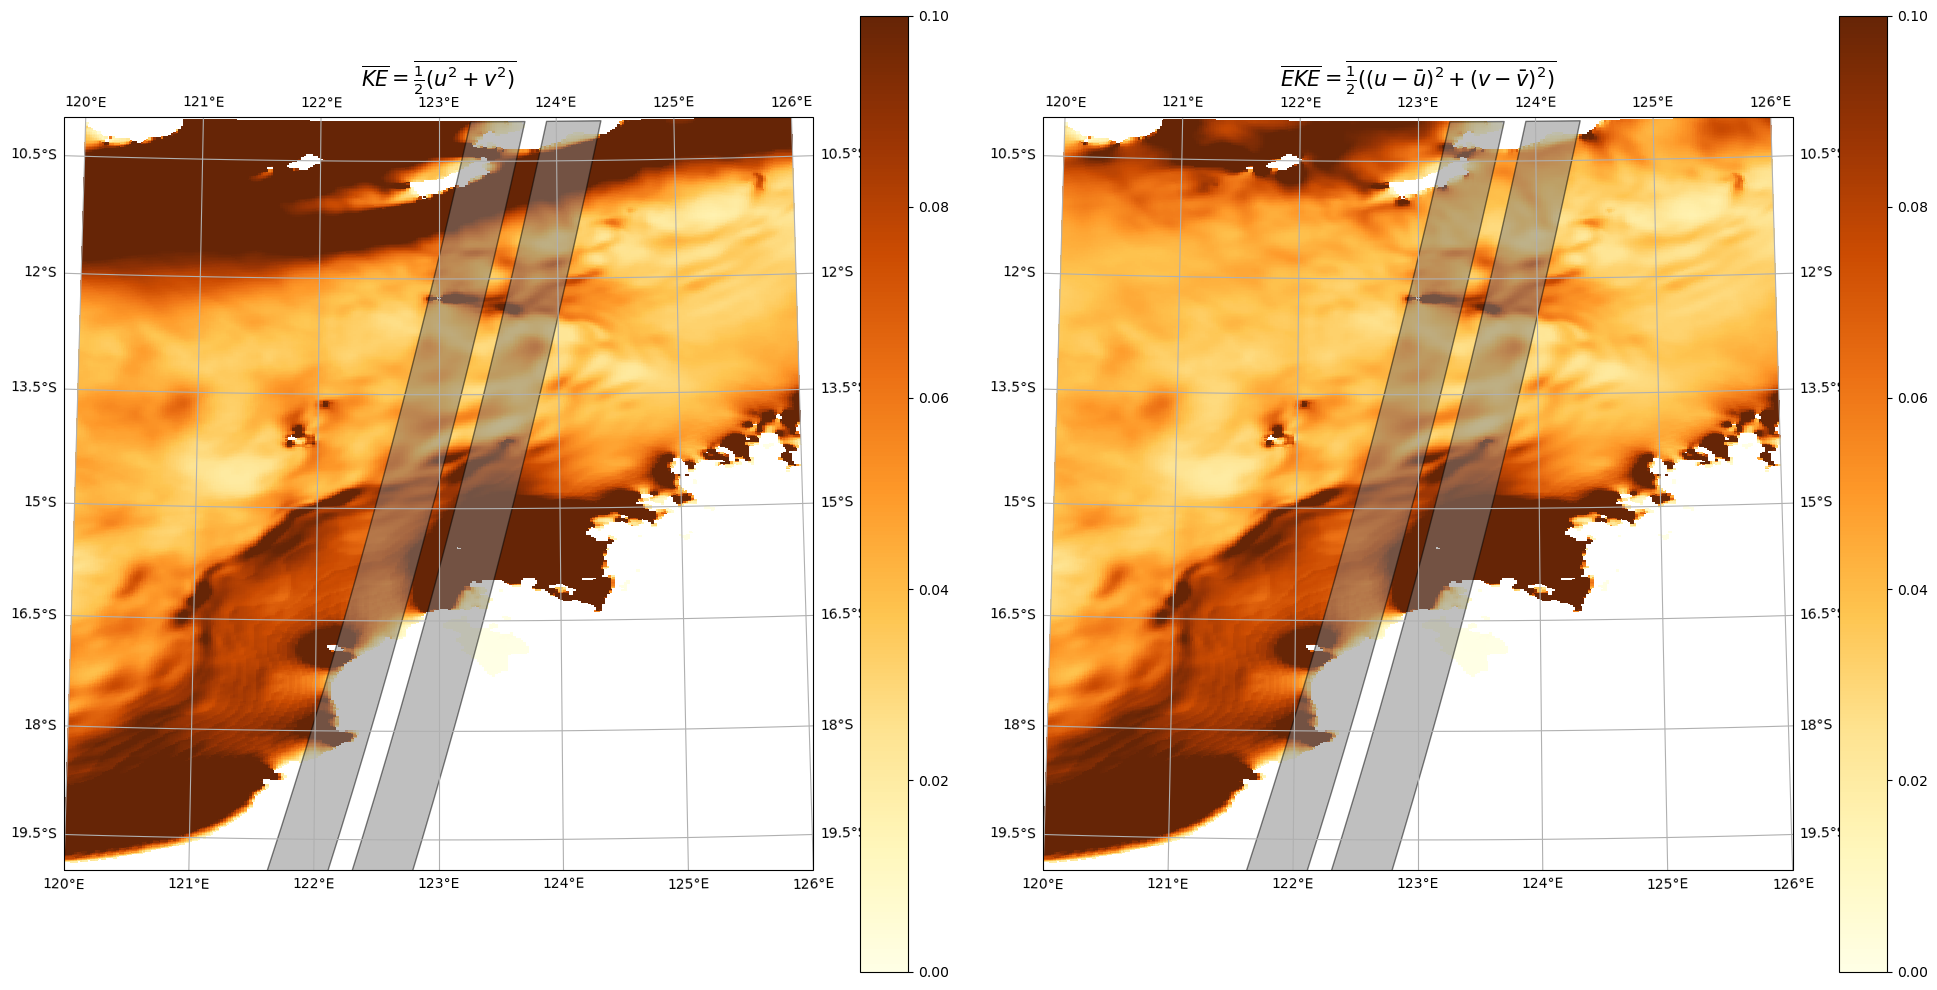

In [17]:
out_dir_nwa = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_nwa")
bbox = [120, 126, -20, -10] # North-west Australia
sli = 10
MKE_nwa = plot_KE(out_dir_nwa,bbox,sli,0.1)

Text(0.5, 1.0, '$\\overline{EKE} = \\overline{\\frac{1}{2}((u-\\bar u)^2+(v-\\bar v)^2)}$')

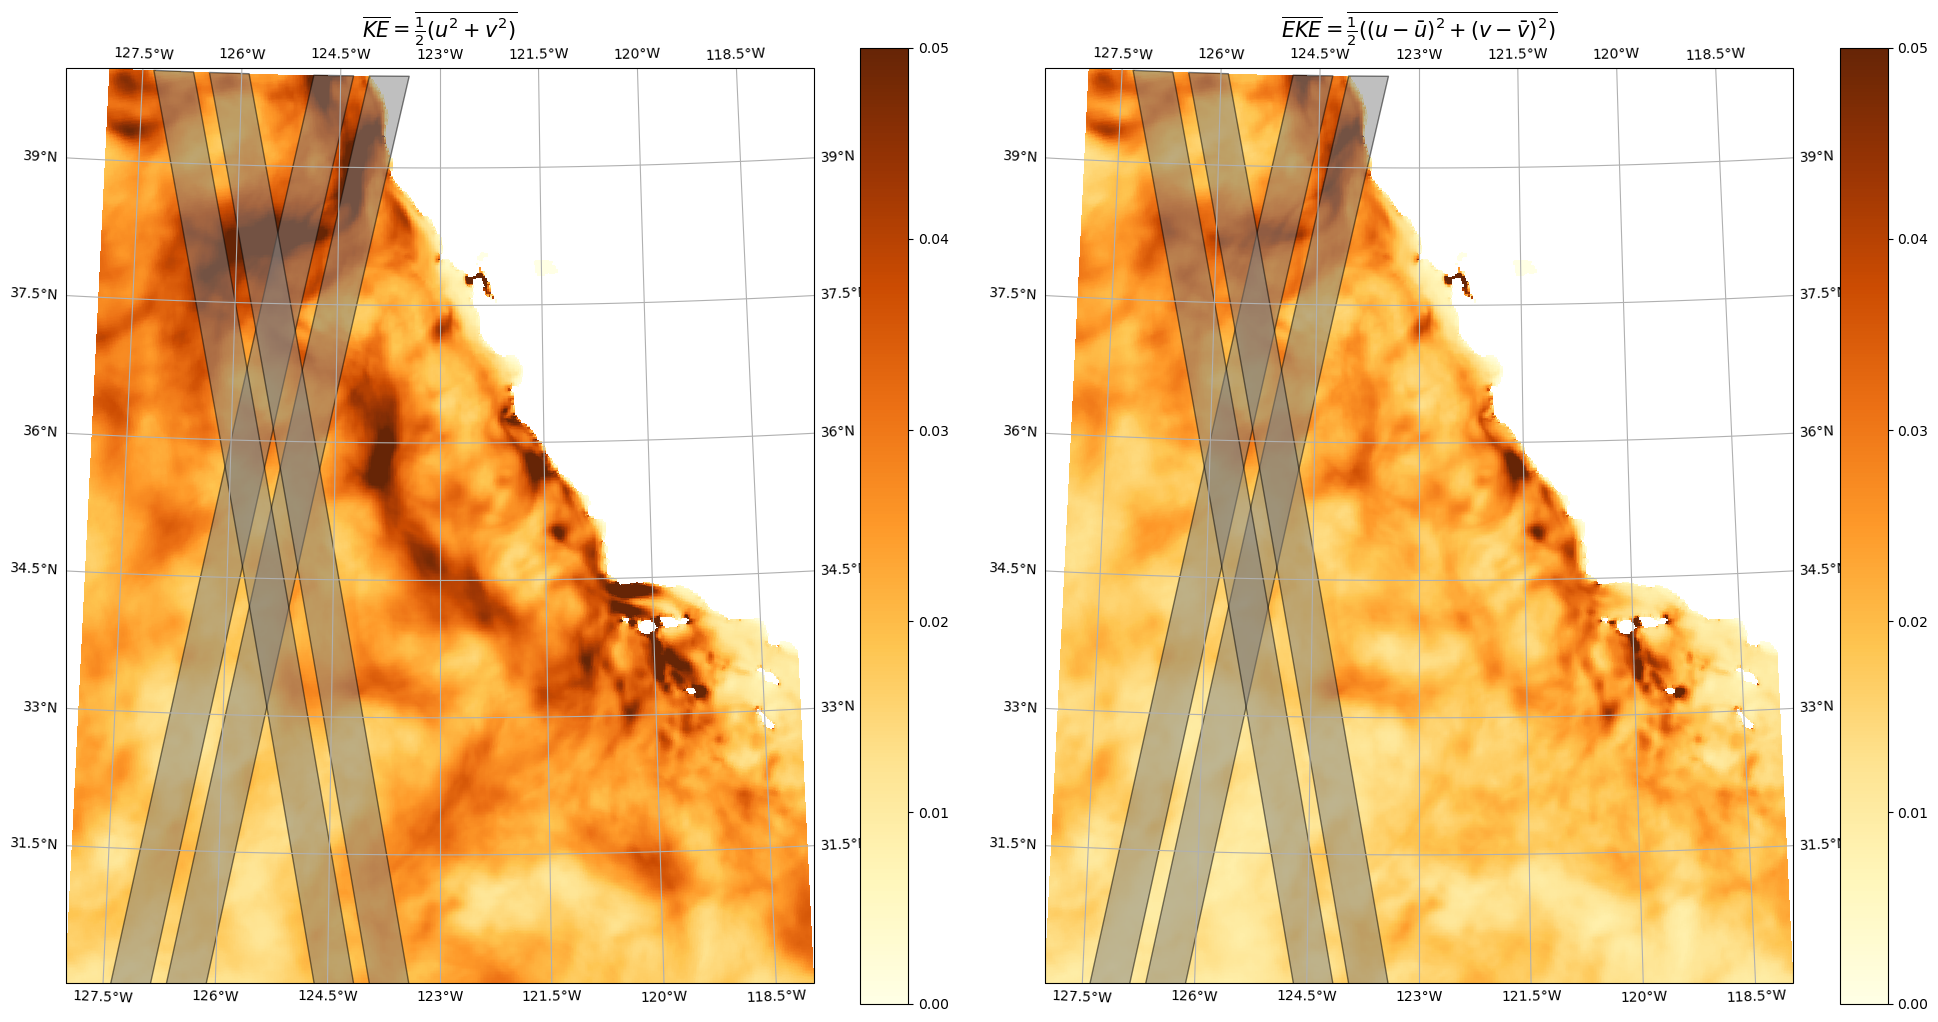

In [45]:
sli = 15
bbox = [-128, -118, 30, 40] # california

fig,axs = plot_site(bbox,2,figsize=(20,10))

cs = axs[0].pcolormesh(KE.lon,KE.lat,KE.KE,
                       transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=0.05,vmin=0)
plt.colorbar(cs,ax=axs[0])
#axs[0].quiver(ds_mean.lon.values[::sli,::sli],ds_mean.lat.values[::sli,::sli],
#              ds_mean.zonal_velocity_var.values[::sli,::sli],ds_mean.meridional_velocity_var.values[::sli,::sli],
#              transform=ccrs.PlateCarree(),scale=3)
cs = axs[1].pcolormesh(EKE.lon,EKE.lat,EKE.EKE,
                       transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=0.05,vmin=0)
plt.colorbar(cs,ax=axs[1])
#axs[1].quiver(ds_mean.lon.values[::sli,::sli],ds_mean.lat.values[::sli,::sli],
#              ds_mean.zonal_velocity_var.values[::sli,::sli],ds_mean.meridional_velocity_var.values[::sli,::sli],
#              transform=ccrs.PlateCarree(),scale=3)
fig.tight_layout()
axs[0].set_title(r'$\overline{KE} = \overline{\frac{1}{2}(u^2+v^2)}$',fontsize=15)
axs[1].set_title(r'$\overline{EKE} = \overline{\frac{1}{2}((u-\bar u)^2+(v-\bar v)^2)}$',fontsize=15)

In [5]:
# output archives
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_california")
llc_zarr = os.path.join(out_dir, "llc.zarr")

parcels_index= 'time_mean'
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)



In [6]:
ds = xr.open_zarr(llc_zarr)

In [7]:
ds['zonal_velocity_var'] = (ds['zonal_velocity']-ds['zonal_velocity'].mean('time'))**2
ds['meridional_velocity_var'] = (ds['meridional_velocity']-ds['meridional_velocity'].mean('time'))**2
ds['zonal_velocity_square'] = ds['zonal_velocity']**2
ds['meridional_velocity_square'] = ds['meridional_velocity']**2

In [8]:
ds_mean = ds.mean('time').compute()

dfE_mean = ds_mean.drop(['face']).to_dataframe()

In [9]:
bbox = [-128, -118, 30, 40] # california
dl = 1.  #2.
lonmin,lonmax = bbox[0],bbox[1]
latmin,latmax = bbox[2],bbox[3]
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)

In [140]:
dfE_mean['lon_cut'] = pd.cut(dfE_mean['lon'], lon)
dfE_mean['lat_cut'] = pd.cut(dfE_mean['lat'], lat)

In [31]:
df_sub = dfE_mean.groupby(['lat_cut'])

In [156]:
df_lonlat = df_sub.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))

In [147]:
df_lat = dfE_mean.groupby(['lat_cut']).apply(lambda x:x.mean(skipna=True))

In [105]:
df_lonlat_count = df_sub.groupby(['lon_cut','lat_cut']).count()

In [106]:
df_lonlat_count = pa.add_geodata(df_lonlat_count,lonlat=['lon_cut','lat_cut'])
df_lonlat_count = (df_lonlat_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])['zonal_velocity']
         .to_xarray()
        )

In [157]:
df_lonlat = pa.add_geodata(df_lonlat,lonlat=['lon_cut','lat_cut'])
df_lonlat = (df_lonlat
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])
         .to_xarray()
        )

In [148]:
df_lat = pa.add_geodata(df_lat,lonlat=['lat_cut'])
df_lat = (df_lat
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lat_cut']])
         .to_xarray()
        )

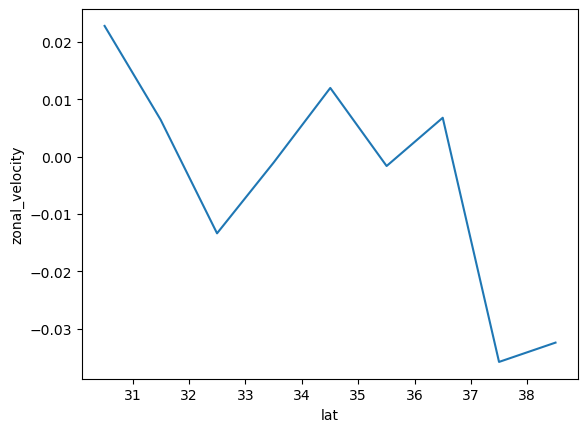

In [151]:
df_lat.zonal_velocity.plot()

(36.0, 37.0)

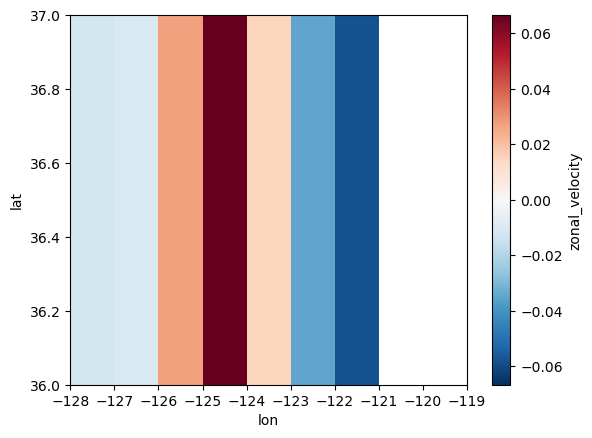

In [116]:
df_lonlat.zonal_velocity.plot(y='lat')
plt.ylim(36,37)

(-128.0, -119.0)

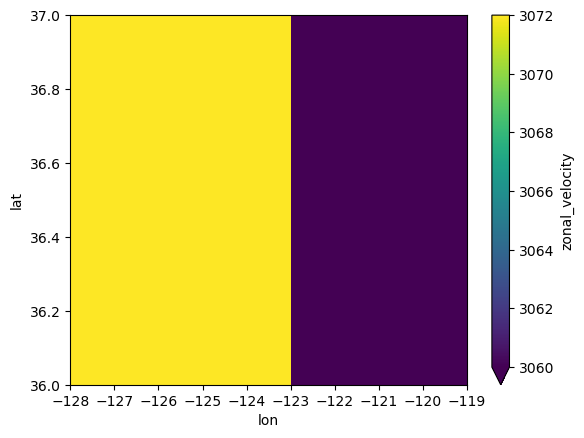

In [164]:
df_lonlat_count.plot(y='lat',vmin=3060)
plt.ylim(36,37);plt.xlim()

In [158]:
df_lonlat.zonal_velocity.mean(dim='lon',skipna=True).isel(lat=6)

<xarray.DataArray 'zonal_velocity' ()>
array(0.01711603)
Coordinates:
    lat      float64 36.5

In [155]:
df_lat.zonal_velocity.isel(lat=6)

<xarray.DataArray 'zonal_velocity' ()>
array(0.00678267)
Coordinates:
    lat      float64 36.5

In [78]:
from xhistogram.xarray import histogram

N = histogram(ds_mean.lon.load(), ds_mean.lat.load(), 
                bins=[lon, lat], 
                dim=['i', 'j'], 
                block_size=None
                     )

In [79]:
E_u = histogram(ds_mean.lon.load(), ds_mean.lat.load(),bins=[lon, lat], 
                      weights= ds_mean["zonal_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_u = (E_u/N).rename('E_%s'%('zonal_velocity')).rename({'lon_bin': 'lon','lat_bin': 'lat'})    

In [84]:
N_lat = histogram(ds_mean.lat.load(), 
                bins=[lat], 
                dim=['i', 'j'], 
                block_size=None
                     )
E_u_lat = histogram(ds_mean.lat.load(),bins=[lat], 
                      weights= ds_mean["zonal_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_u_lat = (E_u_lat/N_lat).rename('E_%s'%('zonal_velocity')).rename({'lat_bin': 'lat'})    

In [86]:
E_v_lat = histogram(ds_mean.lat.load(),bins=[lat], 
                      weights= ds_mean["meridional_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_v_lat = (E_v_lat/N_lat).rename('E_%s'%('meridional_velocity')).rename({'lat_bin': 'lat'})    

In [80]:
E_v = histogram(ds_mean.lon.load(), ds_mean.lat.load(),bins=[lon, lat], 
                      weights= ds_mean["meridional_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_v = (E_v/N).rename('E_%s'%('meridional_velocity')).rename({'lon_bin': 'lon','lat_bin': 'lat'})    

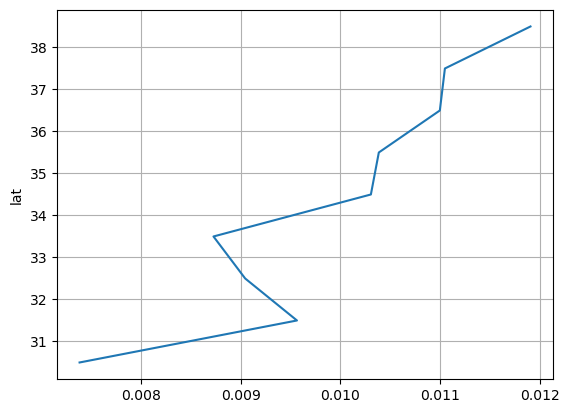

In [32]:
(E_u**2+E_v**2).mean('lon').plot(y='lat')
plt.grid()

In [ ]:
ds_mean['MKE'] = ds_mean['zonal_velocity']**2+ds_mean['meridional_velocity']**2

In [10]:
def binned_mean(df,dl,bbox,k,group,skipna=False):
    lonmin,lonmax = bbox[0],bbox[1]
    latmin,latmax = bbox[2],bbox[3]
    lon = np.arange(lonmin,lonmax+dl, dl)
    lat = np.arange(latmin, latmax+dl, dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    #df_count = df.groupby(group).apply(lambda x:x.count())
    #df_count = pa.add_geodata(df_count,lonlat=group)
    #f_count = (df_count
     #     .drop(columns=['Coordinates'])
    #      .set_index([V.split('_')[0] for V in group])
    #     .to_xarray()
    #    )
    #df_count = df_count.assign_coords({V.split('_')[0]:np.around(df[V.split('_')[0]],decimals=k) for V in group})
    if len(group)==1:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=True))
    else:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=skipna))
    df = pa.add_geodata(df,lonlat=group)
    df = (df
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    #df = df.assign_coords({V.split('_')[0]:np.around(df[V.split('_')[0]],decimals=k) for V in group})
    #df['count'] = df_count.zonal_velocity
    #df = df.assign_coords({'lat':np.around(df.lat,decimals=k)
    #                                                 ,'lon':np.around(df.lon,decimals=k)})
    return df

In [11]:
def binned_Lmean(df,dl,bbox,group,skipna=False):
    lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
    latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
    lon = np.arange(lonmin,lonmax+dl, dl)
    lat = np.arange(latmin, latmax+dl, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_reset = df.reset_index()
    #group = ['lon_cut','lat_cut']
    #df_count = df.groupby(group).count()
    #df_count = pa.add_geodata(df_count,lonlat=group)
    #df_count = (df_count
     #     .drop(columns=['Coordinates'])
    #      .set_index([V.split('_')[0] for V in group])
    #     .to_xarray()
    #    )
    df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).agg(lambda x: x.mean(skipna=skipna))
    df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})
    df_merged = (df_reset
                 .merge(df_mean.reset_index(), on=group)
                )
    df_merged = df_merged.set_index('time')
    for V in ['zonal_velocity','meridional_velocity']:
        df_merged[V+'_var_ibinned'] = (df_merged[V]-df_merged[V+'_mean_binned'])**2
        df_merged[V+'_var_binned'] = (df_merged[V]-df_merged[V+'_binned'])**2
        df_merged[V+'_var_itime'] = (df_merged[V]-df_merged[V+'_mean'])**2
        df_merged[V+'_square'] = df_merged[V]**2
    df_merged['MKE_itime'] = df_merged['zonal_velocity_mean']**2+df_merged['meridional_velocity_mean']**2
    df_merged['KE'] = df_merged['zonal_velocity']**2+df_merged['meridional_velocity']**2
    #dfL_mean = df_merged.groupby(['lon_cut','lat_cut']).agg(lambda x: x.mean(skipna=False))
    #dfL_mean = pa.add_geodata(dfL_mean)
    #dfL_mean = (dfL_mean
    #          .set_index(['lon', 'lat'])
    #         .to_xarray()
    #        )
    if len(group)==1:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=True))
    else:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=skipna))
    dfL_mean = pa.add_geodata(dfL_mean,lonlat=group)
    dfL_mean = (dfL_mean
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    #dfL_mean['count'] = df_count.zonal_velocity
    return dfL_mean,df_merged#,df_count

#### Test Eulerian differences lat_cut or [lon_cut,lat_cut]

In [13]:
bbox = [-128, -118, 30, 40] # california
dl=1.
group = ['lon_cut','lat_cut']
#dfE_1dl,dfE_count_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl_skipna = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=False)
dfE_1dlat = binned_mean(dfE_mean,1.,bbox,1,['lat_cut'])

In [14]:
for V in [dfE_1dl_skipna,dfE_1dl,dfE_1dlat]:#,[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
    V['MKE'] = V['zonal_velocity']**2+V['meridional_velocity']**2
    #V['EKE'] = V['zonal_velocity_var']+V['meridional_velocity_var']

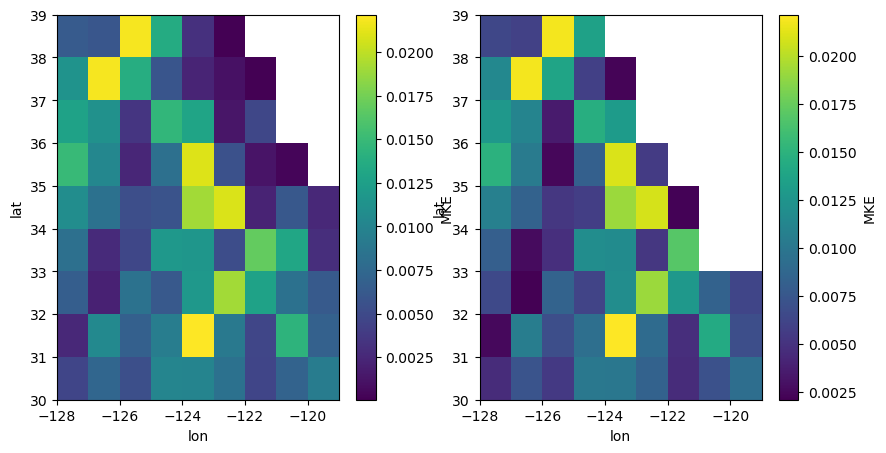

In [93]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
dfE_1dl_skipna.MKE.plot(y='lat',ax=ax[0])
dfE_1dl.MKE.plot(y='lat',ax=ax[1])

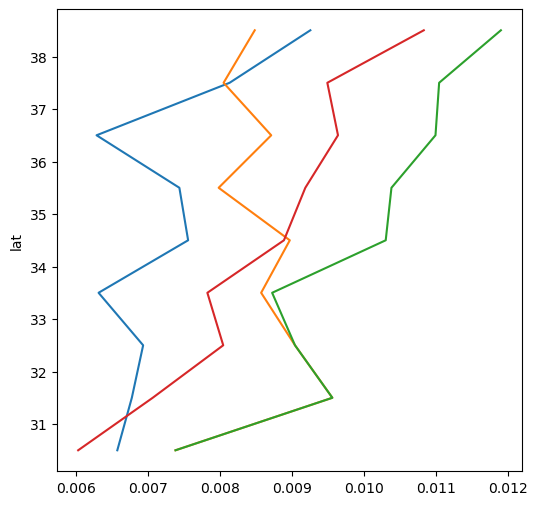

In [54]:
fig,ax = plt.subplots(figsize=(6,6))
dfE_1dlat.MKE.plot(ax=ax,y='lat',label='')
dfE_1dl_skipna.mean('lon').MKE.plot(ax=ax,y='lat')
dfE_1dl.MKE.mean('lon').plot(ax=ax,y='lat')
(E_u.mean('lon')**2+E_v.mean('lon')**2).plot(ax=ax,y='lat')

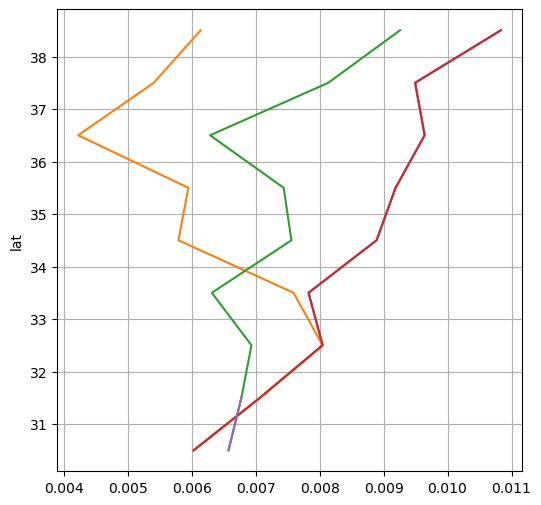

In [94]:
fig,ax = plt.subplots(figsize=(6,6))
(dfE_1dl.zonal_velocity.mean('lon')**2+dfE_1dl.meridional_velocity.mean('lon')**2).plot(ax=ax,y='lat')
(dfE_1dl_skipna.zonal_velocity.mean('lon')**2+dfE_1dl_skipna.meridional_velocity.mean('lon')**2).plot(ax=ax,y='lat')
dfE_1dlat.MKE.plot(ax=ax,y='lat',label='')
(E_u.mean('lon')**2+E_v.mean('lon')**2).plot(ax=ax,y='lat')
(E_u_lat**2+E_v_lat**2).plot(ax=ax,y='lat')


ax.grid()

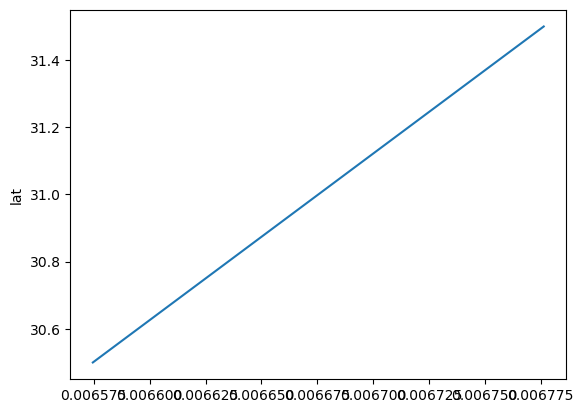

In [95]:
(E_u_lat**2+E_v_lat**2).plot(y='lat')



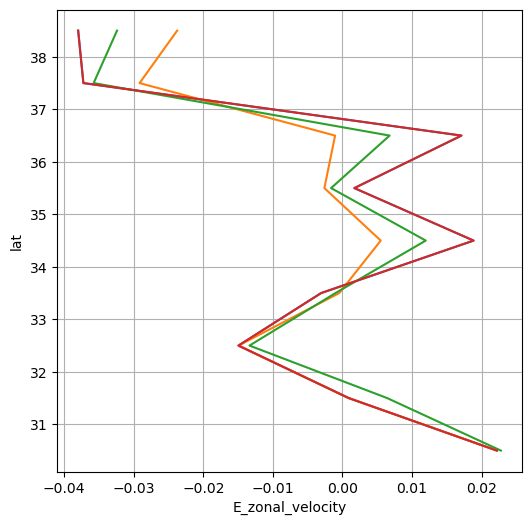

In [57]:
fig,ax = plt.subplots(figsize=(6,6))
(dfE_1dl.zonal_velocity.mean('lon')).plot(ax=ax,y='lat')
(dfE_1dl_skipna.zonal_velocity.mean('lon')).plot(ax=ax,y='lat')
dfE_1dlat.zonal_velocity.plot(ax=ax,y='lat',label='')
(E_u.mean('lon')).plot(ax=ax,y='lat')

ax.grid()

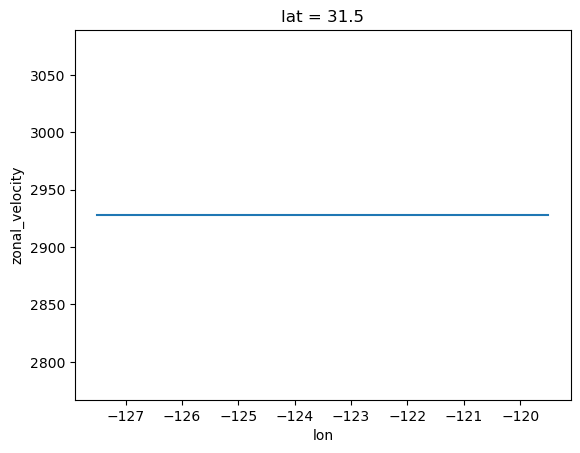

In [68]:
_dfE_count.zonal_velocity.isel(lat=1).plot()

In [59]:
_dfE_mean = dfE_mean.copy()
lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)
#_dfE_mean['lon'] = (_dfE_mean['lon']+180)%360 - 180
_dfE_mean['lon_cut'] = pd.cut(_dfE_mean['lon'], lon)
_dfE_mean['lat_cut'] = pd.cut(_dfE_mean['lat'], lat)
#df_reset = _dfE_mean.reset_index()

In [87]:
_dfE_mean = _dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))

In [88]:
_dfE_mean_lat = _dfE_mean.groupby(['lat_cut']).mean()

In [81]:
_dfE_mean_lat

Depth        lat    lon  meridional_velocity  \
lat_cut                                                            
(30.0, 31.0]  4058.078315  30.501771 -123.5            -0.074412   
(31.0, 32.0]  3989.212836  31.496087 -123.5            -0.084057   
(32.0, 33.0]  3758.105808  32.496521 -123.5            -0.088449   
(33.0, 34.0]  3574.512648  33.502423 -123.5            -0.087128   
(34.0, 35.0]  3263.642170  34.505236 -123.5            -0.075907   
(35.0, 36.0]  2912.929278  35.504541 -123.5            -0.077069   
(36.0, 37.0]  2610.083637  36.499984 -123.5            -0.064983   
(37.0, 38.0]  2199.048680  37.498779 -123.5            -0.067498   
(38.0, 39.0]  1876.381834  38.500335 -123.5            -0.074667   

              zonal_velocity  zonal_velocity_var  meridional_velocity_var  
lat_cut                                                                    
(30.0, 31.0]        0.022211            0.012992                 0.014726  
(31.0, 32.0]        0.000906            0.014609                 0.015973  
(32.0, 33.0]       -0.014946            0.015023                 0.017858  
(33.0, 34.0]       -0.000456            0.018940                 0.020736  
(34.0, 35.0]        0.005508            0.017081                 0.020432  
(35.0, 36.0]       -0.002597            0.019959                 0.023174  
(36.0, 37.0]       -0.001054            0.018655                 0.025276  
(37.0, 38.0]       -0.029172            0.016922                 0.024319  
(38.0, 39.0]       -0.023760            0.017999                 0.029148

In [60]:
_dfE_count = _dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.count())

In [90]:
_dfE_mean = pa.add_geodata(_dfE_mean,lonlat=['lon_cut','lat_cut'])
_dfE_mean = (_dfE_mean
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])
         .to_xarray()
        )

In [91]:
_dfE_mean_lat = pa.add_geodata(_dfE_mean_lat,lonlat=['lat_cut'])
_dfE_mean_lat = (_dfE_mean_lat
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lat_cut']])
         .to_xarray()
        )

In [92]:
_dfE_mean['MKE'] = _dfE_mean['zonal_velocity']**2+_dfE_mean['meridional_velocity']**2
_dfE_mean_lat['MKE'] = _dfE_mean_lat['zonal_velocity']**2+_dfE_mean_lat['meridional_velocity']**2

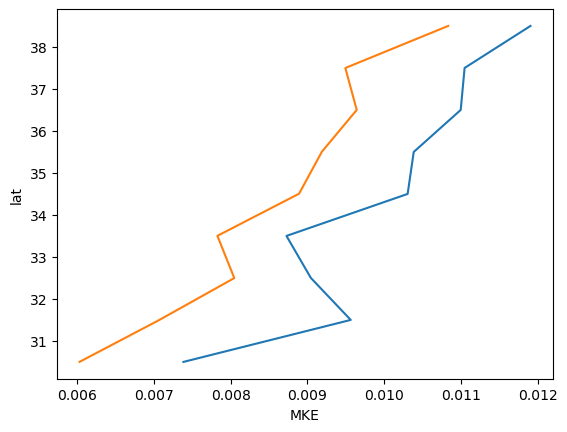

In [93]:
_dfE_mean.mean('lon').MKE.plot(y='lat')
_dfE_mean_lat.MKE.plot(y='lat')

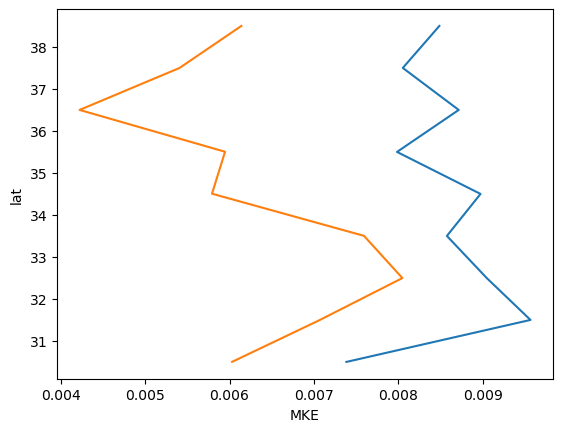

In [85]:
_dfE_mean.mean('lon').MKE.plot(y='lat')
_dfE_mean_lat.MKE.plot(y='lat')

In [63]:
_dfE_count = pa.add_geodata(_dfE_count,lonlat=['lon_cut','lat_cut'])
_dfE_count = (_dfE_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])
         .to_xarray()
        )

<AxesSubplot:xlabel='lon_cut,lat_cut'>

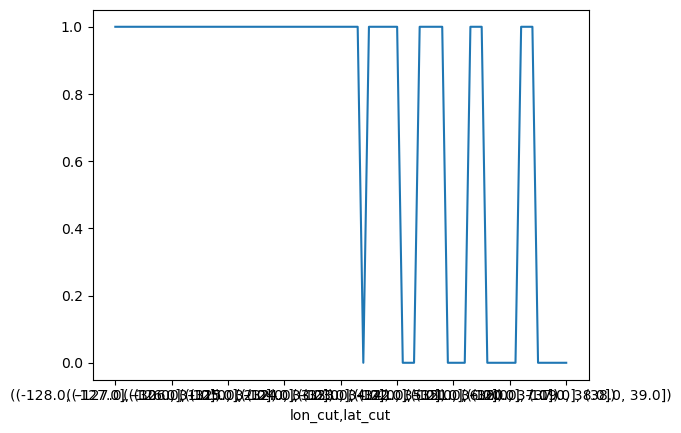

In [95]:
_dfE_count.zonal_velocity.plot(
                              )

In [ ]:
bbox = [-128, -118, 30, 40] # california
dl=.1
dfE_01dl = binned_mean(dfE_mean,dl,bbox,2,group,skipna=True)

### PDFs

In [36]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
def plot_site(bbox,k,colmap='RdBu_r',figsize=(5,5)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, k, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    for a in ax:
        a.add_geometries(gdf_crs['geometry'],
                          crs=crs,
                          facecolor='grey', 
                          edgecolor='black',
                          alpha=0.5,
                         )

        a.gridlines(draw_labels=True)
    #    ax.coastlines(resolution='50m')
        a.set_extent(bbox)
    return fig, ax

In [15]:
bbox = [-128, -118, 30, 40] # california
dl=1.
group = ['lon_cut','lat_cut']
#dfE_1dl,dfE_count_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl_skipna = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=False)
dfE_1dlat = binned_mean(dfE_mean,1.,bbox,1,['lat_cut'])

In [16]:
#Lagrangian outputs
df = dd.read_parquet(parcels_path)

In [17]:
df = df.drop(columns=['SST_interp','SSS_interp','Eta_interp','salinity','temperature','sea_level']).rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})
df = pa.degs2ms(df) #Convert in m/s 
df= df.compute()

In [18]:
group=['lon_cut','lat_cut']
dfL_1dl_skipna,df_merged_skipna = binned_Lmean(df,1.,bbox,group=group,skipna=True)
dfL_1dl,df_merged = binned_Lmean(df,1.,bbox,group=group,skipna=False)

In [19]:
for V in [[dfE_1dl,dfL_1dl],[dfE_1dl_skipna,dfL_1dl_skipna]]:#,[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
    V[0]['MKE'] = V[0]['zonal_velocity']**2+V[0]['meridional_velocity']**2
    V[0]['EKE'] = V[0]['zonal_velocity_var']+V[0]['meridional_velocity_var']
    c
    V[1]['MKE_i'] = V[1]['zonal_velocity_mean']**2+V[1]['meridional_velocity_mean']**2
    V[1]['MKE_b'] = V[1]['zonal_velocity']**2+V[1]['meridional_velocity']**2
    V[1]['EKE_i'] = V[1]['zonal_velocity_var_itime']+V[1]['meridional_velocity_var_itime']
    V[1]['EKE_b'] = V[1]['zonal_velocity_var_binned']+V[1]['meridional_velocity_var_binned']

In [37]:
tracks = ut.load_swot_tracks()

In [99]:
df['MKE'] = df['zonal_velocity_mean']**2+df['meridional_velocity_mean']**2

In [100]:
df_sub = df[(df.lon>=bbox[0])&(df.lon<=bbox[1])&(df.lat>=bbox[2])&(df.lat<=bbox[3])]
#df.plot.scatter(x='lon',y='lat',c='zonal_velocity')

In [109]:
df_sub = df_sub.sort_values(by=['lon','lat'])

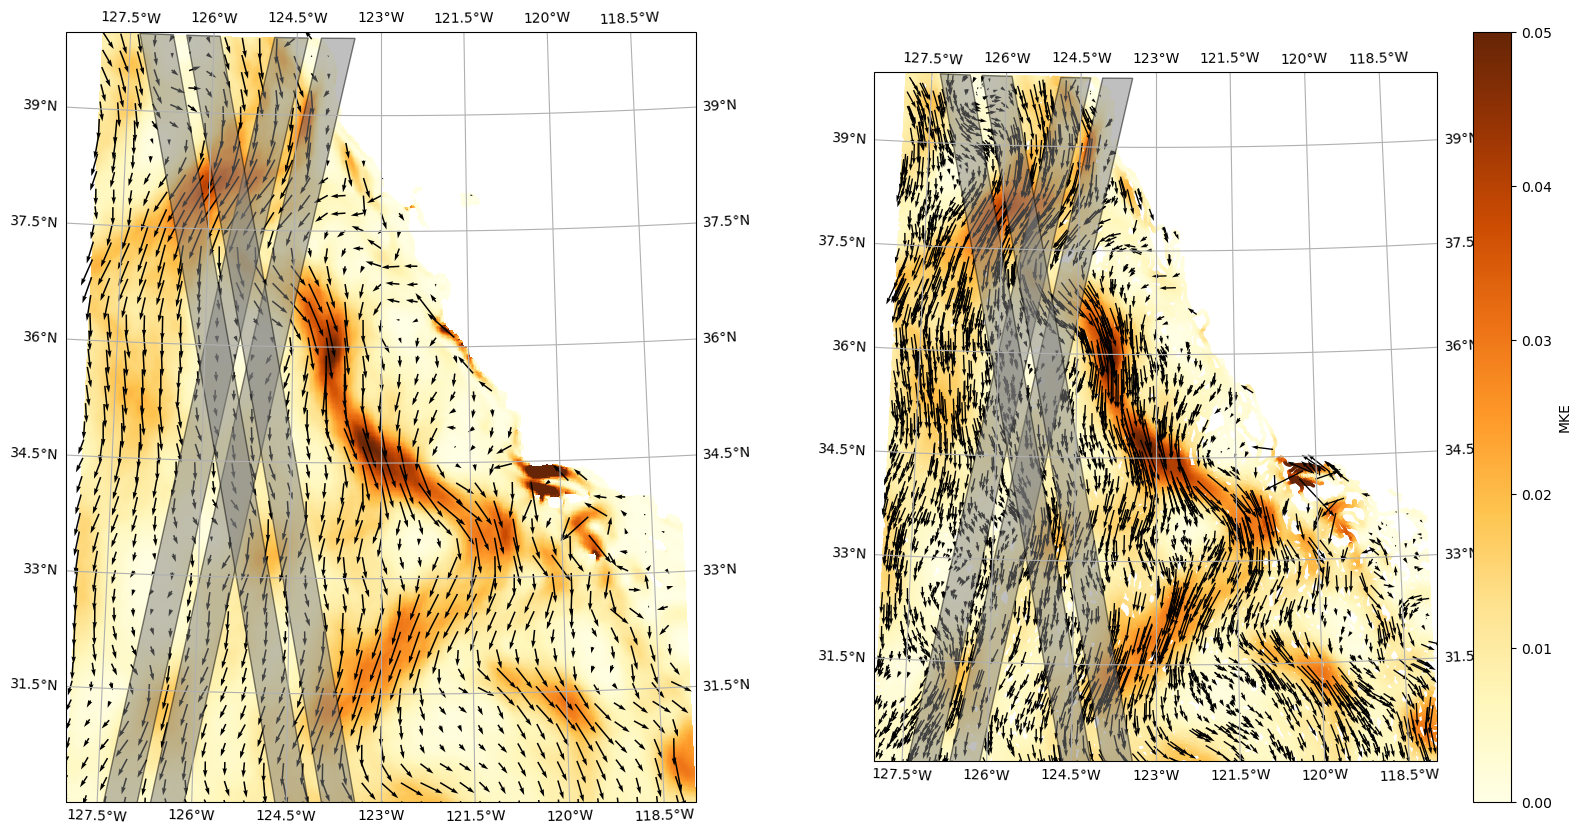

In [120]:
sli = 15
fig,axs = plot_site(bbox,2,figsize=(20,10))
cs = axs[0].pcolormesh(ds_mean.lon,ds_mean.lat,(ds_mean.zonal_velocity**2+ds_mean.meridional_velocity**2),
                       transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=0.05,vmin=0)
#plt.colorbar(cs,ax=axs[0])
axs[0].quiver(ds_mean.lon.values[::sli,::sli],ds_mean.lat.values[::sli,::sli],
              ds_mean.zonal_velocity.values[::sli,::sli],ds_mean.meridional_velocity.values[::sli,::sli],
              transform=ccrs.PlateCarree(),scale=3)
cs1 = df_sub.plot.scatter(x='lon',y='lat',c='MKE',vmax=0.05,vmin=0,ax=axs[1],transform=ccrs.PlateCarree(),s=2,cmap='YlOrBr')
axs[1].quiver(df_sub.lon.values[::sli+250],df_sub.lat.values[::sli+250],
              df_sub.zonal_velocity_mean.values[::sli+250],df_sub.meridional_velocity_mean.values[::sli+250],
              transform=ccrs.PlateCarree(),scale=3)

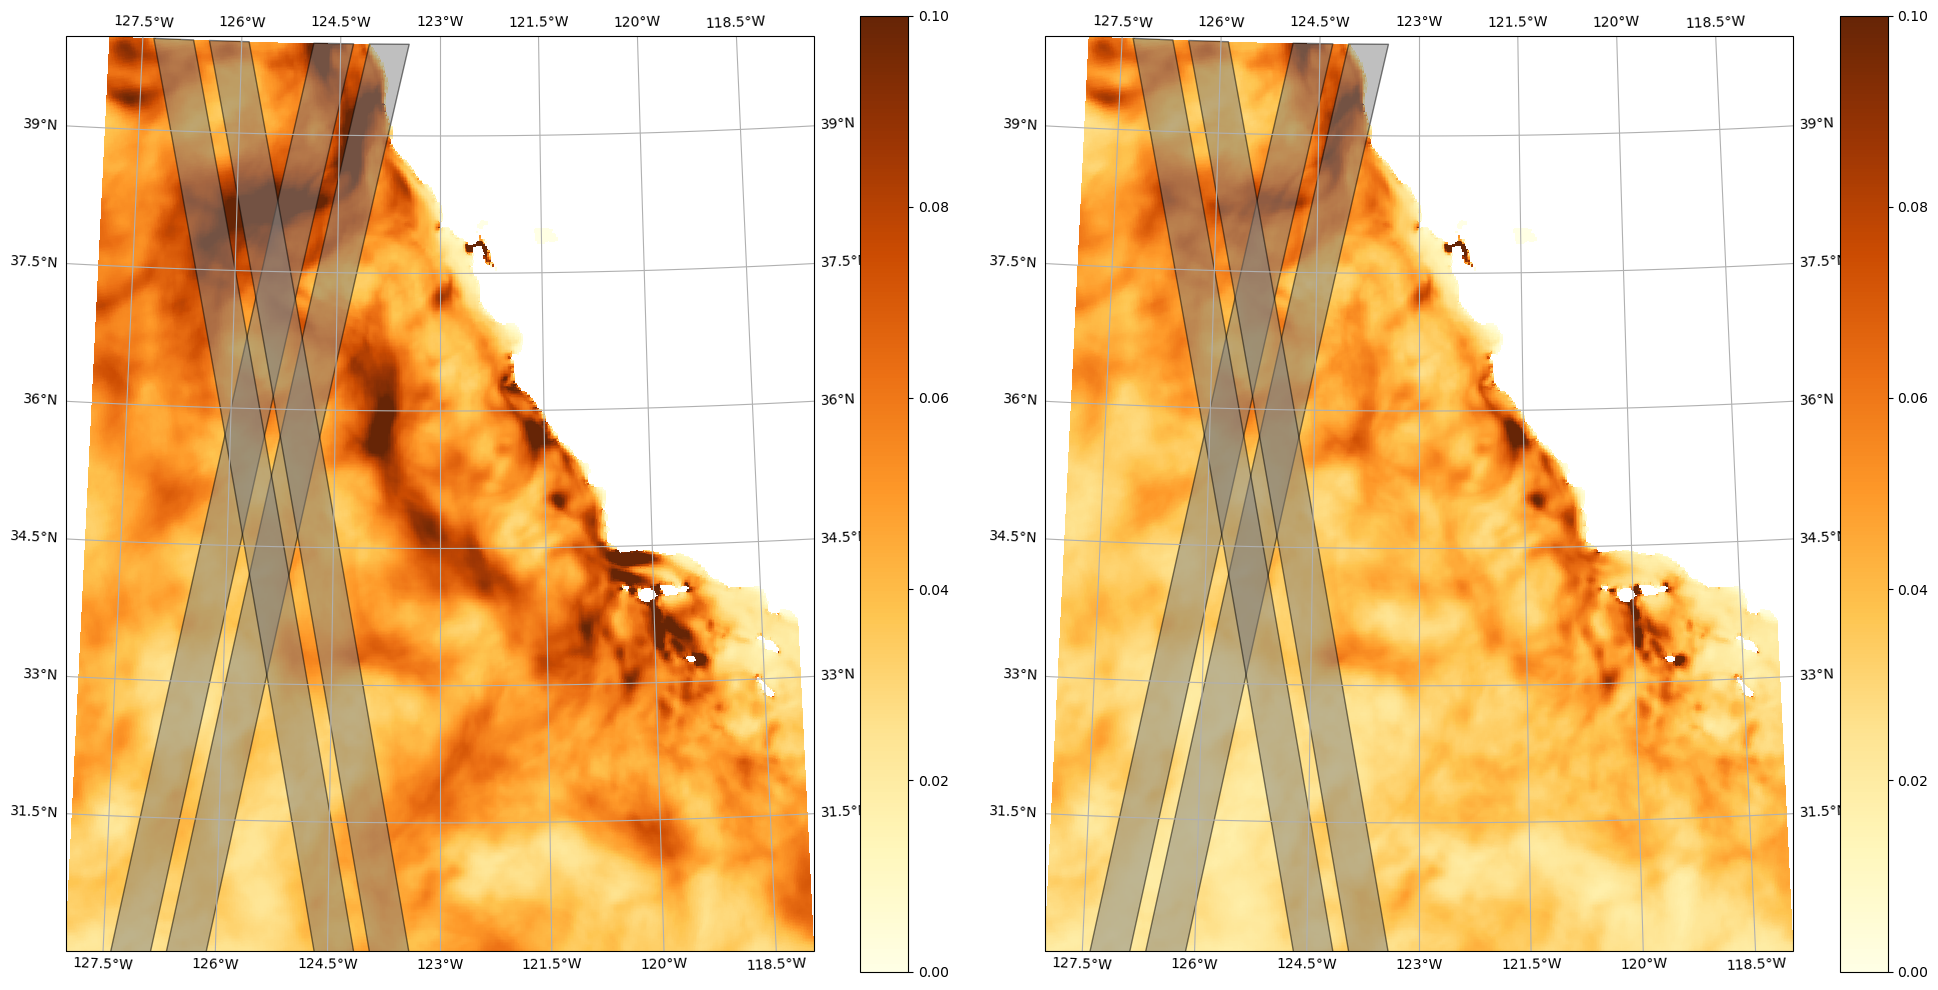

In [131]:
sli = 15
fig,axs = plot_site(bbox,2,figsize=(20,10))
cs = axs[0].pcolormesh(ds_mean.lon,ds_mean.lat,(ds_mean.zonal_velocity_square+ds_mean.meridional_velocity_square),
                       transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=0.1,vmin=0)
plt.colorbar(cs,ax=axs[0])
#axs[0].quiver(ds_mean.lon.values[::sli,::sli],ds_mean.lat.values[::sli,::sli],
#              ds_mean.zonal_velocity_var.values[::sli,::sli],ds_mean.meridional_velocity_var.values[::sli,::sli],
#              transform=ccrs.PlateCarree(),scale=3)
cs = axs[1].pcolormesh(ds_mean.lon,ds_mean.lat,(ds_mean.zonal_velocity_var+ds_mean.meridional_velocity_var),
                       transform=ccrs.PlateCarree(),cmap='YlOrBr',vmax=0.1,vmin=0)
plt.colorbar(cs,ax=axs[1])
#axs[1].quiver(ds_mean.lon.values[::sli,::sli],ds_mean.lat.values[::sli,::sli],
#              ds_mean.zonal_velocity_var.values[::sli,::sli],ds_mean.meridional_velocity_var.values[::sli,::sli],
#              transform=ccrs.PlateCarree(),scale=3)
fig.tight_layout()


In [148]:
dls = np.linspace(0.1,5,40)
K = np.append(np.full(39,3),1)
_ds,dfE_dl,dfL_dl={},{},{}
for dl,k in zip(dls,K):
    dfE_dl[str(dl)] = binned_mean(dfE_mean,dl,bbox,k,group,skipna=False)
    dfL_dl[str(dl)],df_merged = binned_Lmean(df,dl,bbox,group=group,skipna=False)
    for V in [[dfE_dl[str(dl)],dfL_dl[str(dl)]]]:#,[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
        V[0]['MKE'] = V[0]['zonal_velocity']**2+V[0]['meridional_velocity']**2
        V[0]['EKE'] = V[0]['zonal_velocity_var']+V[0]['meridional_velocity_var']
        V[0]['KE'] = V[0]['zonal_velocity_square']+V[0]['meridional_velocity_square']
        V[1]['KE'] = V[1]['zonal_velocity_square']+V[1]['meridional_velocity_square']
        V[1]['MKE_i'] = V[1]['zonal_velocity_mean']**2+V[1]['meridional_velocity_mean']**2
        V[1]['MKE_b'] = V[1]['zonal_velocity']**2+V[1]['meridional_velocity']**2
        V[1]['EKE_i'] = V[1]['zonal_velocity_var_itime']+V[1]['meridional_velocity_var_itime']
        V[1]['EKE_b'] = V[1]['zonal_velocity_var_binned']+V[1]['meridional_velocity_var_binned']
    _ds[str(dl)] = xr.Dataset({'MKE_Ei':(np.abs(dfL_dl[str(dl)].MKE_i-dfE_dl[str(dl)].MKE)/dfE_dl[str(dl)].MKE),
                  'MKE_Eb': (np.abs(dfL_dl[str(dl)].MKE_b-dfE_dl[str(dl)].MKE)/dfE_dl[str(dl)].MKE),
                 'EKE_Ei': (np.abs(dfL_dl[str(dl)].EKE_i-dfE_dl[str(dl)].EKE)/dfE_dl[str(dl)].EKE),
                  'EKE_Eb' : (np.abs(dfL_dl[str(dl)].EKE_b-dfE_dl[str(dl)].EKE)/dfE_dl[str(dl)].EKE),
                  'KE_Eb' : (np.abs(dfL_dl[str(dl)].KE-dfE_dl[str(dl)].KE)/dfE_dl[str(dl)].KE)
                              })

In [149]:
dls = np.linspace(0.1,5,40)
K = np.append(np.full(39,3),1)
_ds_skipna,dfE_dl_skipna,dfL_dl_skipna={},{},{}
for dl,k in zip(dls,K):
    dfE_dl_skipna[str(dl)] = binned_mean(dfE_mean,dl,bbox,k,group,skipna=True)
    dfL_dl_skipna[str(dl)],df_merged = binned_Lmean(df,dl,bbox,group=group,skipna=True)
    for V in [[dfE_dl_skipna[str(dl)],dfL_dl_skipna[str(dl)]]]:#,[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
        V[0]['MKE'] = V[0]['zonal_velocity']**2+V[0]['meridional_velocity']**2
        V[0]['EKE'] = V[0]['zonal_velocity_var']+V[0]['meridional_velocity_var']
        V[0]['KE'] = V[0]['zonal_velocity_square']+V[0]['meridional_velocity_square']
        V[1]['KE'] = V[1]['zonal_velocity_square']+V[1]['meridional_velocity_square']
        V[1]['MKE_i'] = V[1]['zonal_velocity_mean']**2+V[1]['meridional_velocity_mean']**2
        V[1]['MKE_b'] = V[1]['zonal_velocity']**2+V[1]['meridional_velocity']**2
        V[1]['EKE_i'] = V[1]['zonal_velocity_var_itime']+V[1]['meridional_velocity_var_itime']
        V[1]['EKE_b'] = V[1]['zonal_velocity_var_binned']+V[1]['meridional_velocity_var_binned']
    _ds_skipna[str(dl)] = xr.Dataset({'MKE_Ei':(np.abs(dfL_dl_skipna[str(dl)].MKE_i-dfE_dl_skipna[str(dl)].MKE)/dfE_dl_skipna[str(dl)].MKE),
                  'MKE_Eb': (np.abs(dfL_dl_skipna[str(dl)].MKE_b-dfE_dl_skipna[str(dl)].MKE)/dfE_dl_skipna[str(dl)].MKE),
                 'EKE_Ei': (np.abs(dfL_dl_skipna[str(dl)].EKE_i-dfE_dl_skipna[str(dl)].EKE)/dfE_dl_skipna[str(dl)].EKE),
                  'EKE_Eb' : (np.abs(dfL_dl_skipna[str(dl)].EKE_b-dfE_dl_skipna[str(dl)].EKE)/dfE_dl_skipna[str(dl)].EKE),
                   'KE_Eb' : (np.abs(dfL_dl_skipna[str(dl)].KE-dfE_dl_skipna[str(dl)].KE)/dfE_dl_skipna[str(dl)].KE)
                                     })

#### Notes : 


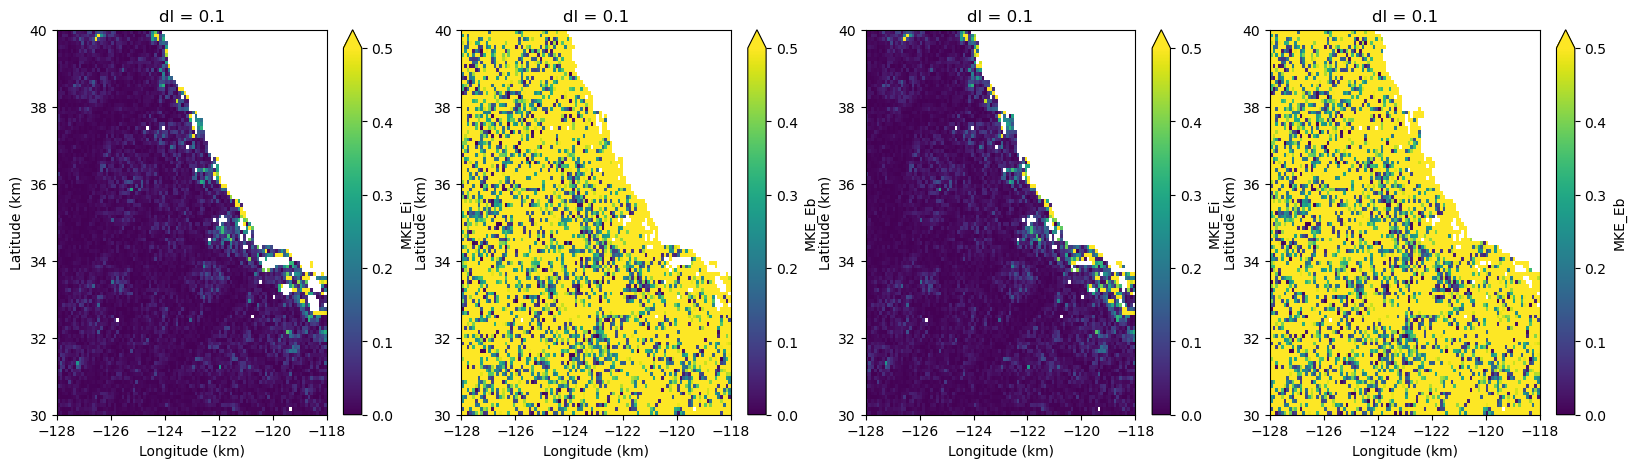

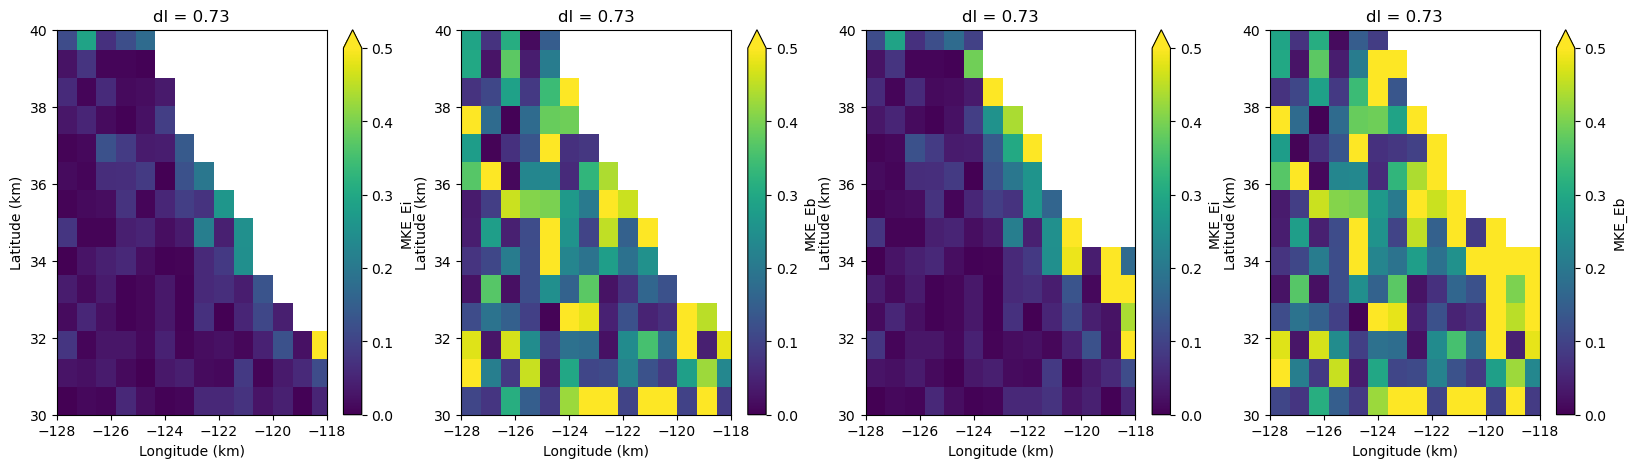

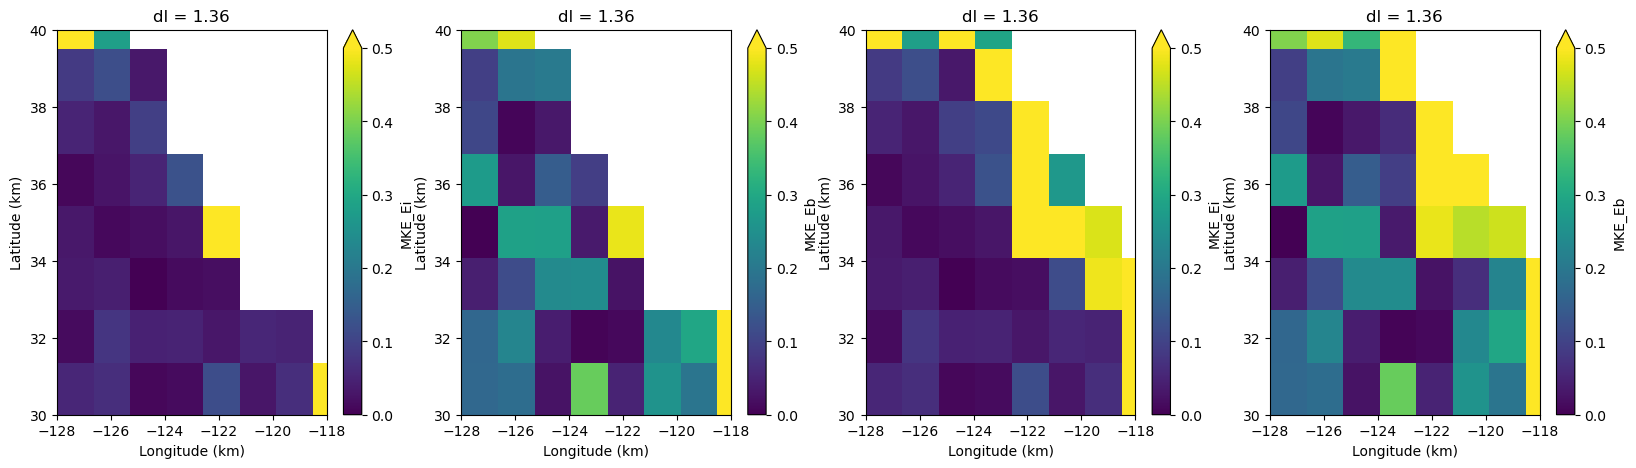

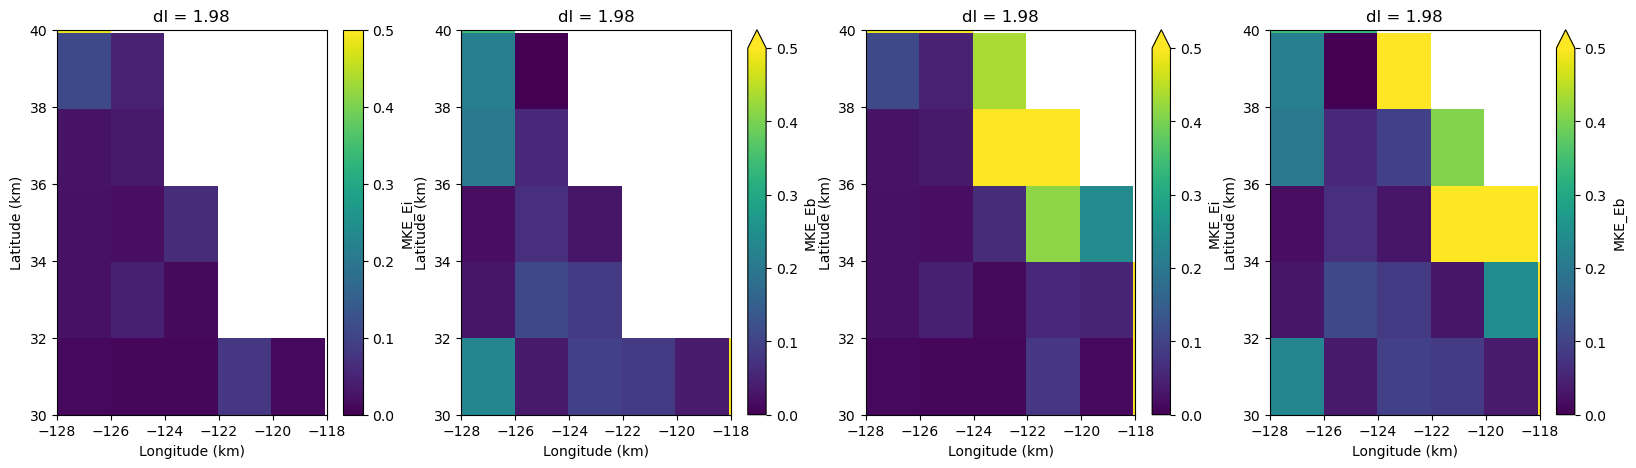

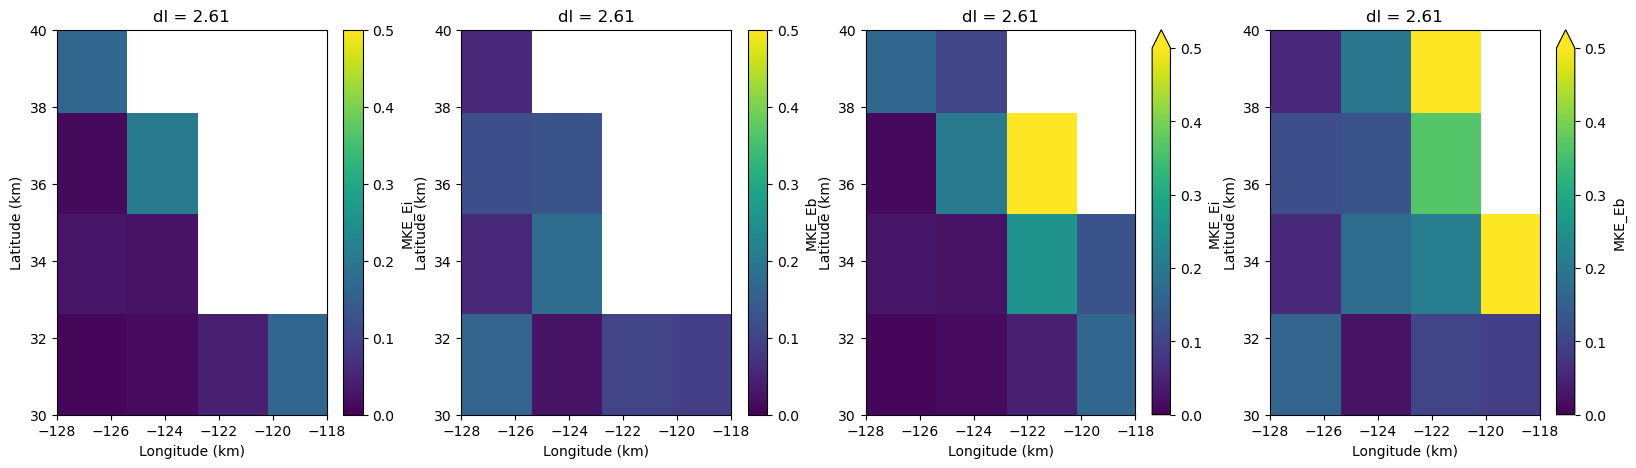

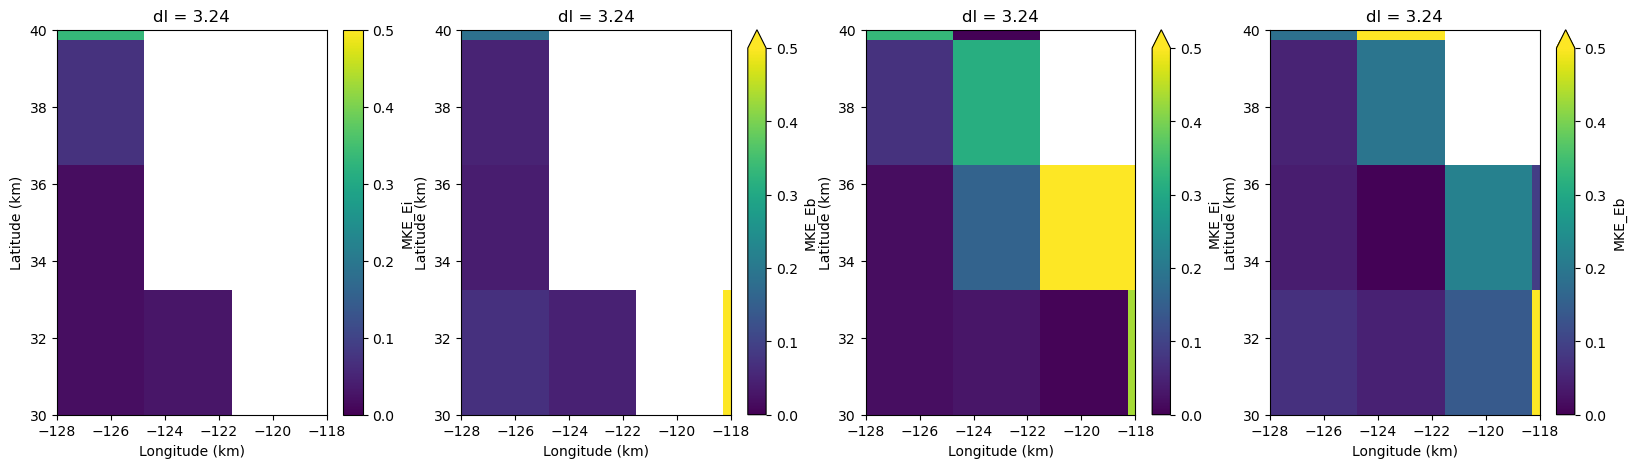

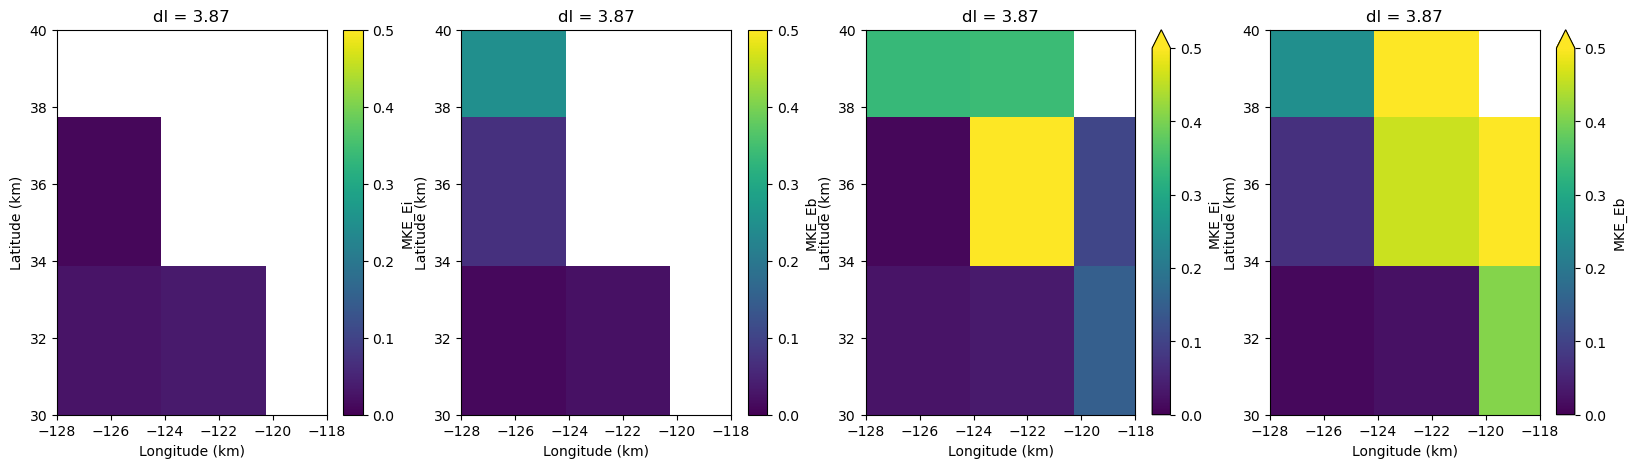

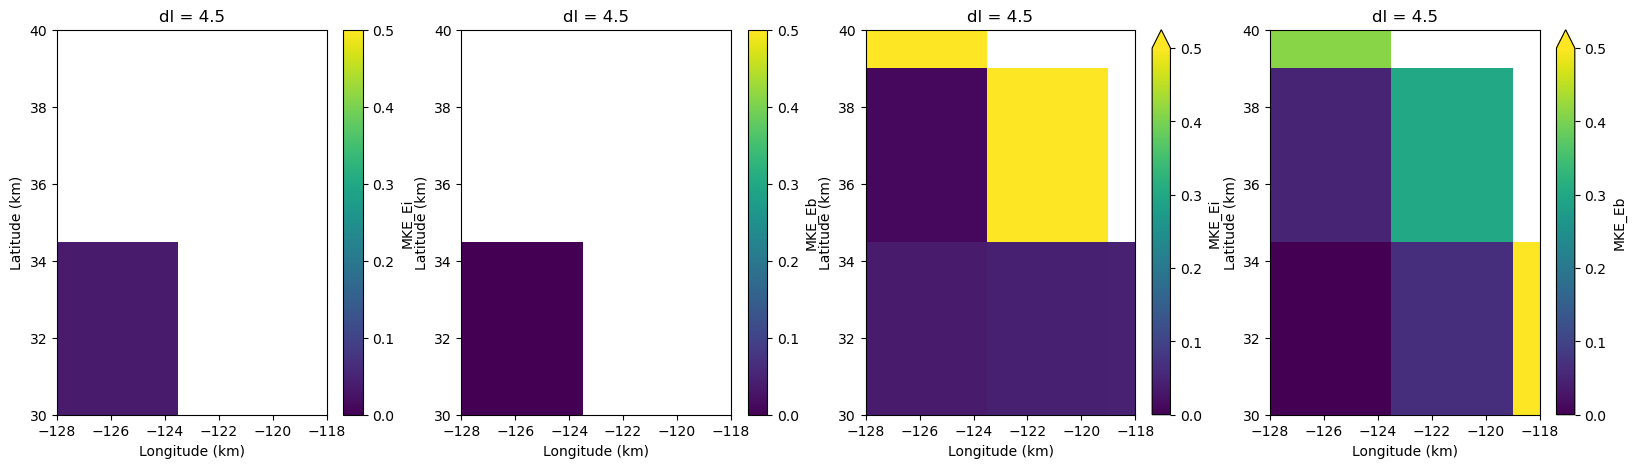

In [163]:
for i, dl in enumerate(_ds.keys()):
    if i%5==0:
        fig,ax = plt.subplots(1,4,figsize=(20,5))
        _ds[dl].MKE_Ei.plot(y='lat',ax=ax[0],vmin=0,vmax=0.5)
        _ds[dl].MKE_Eb.plot(y='lat',ax=ax[1],vmin=0,vmax=0.5)
        _ds_skipna[dl].MKE_Ei.plot(y='lat',ax=ax[2],vmin=0,vmax=0.5)
        _ds_skipna[dl].MKE_Eb.plot(y='lat',ax=ax[3],vmin=0,vmax=0.5)
        for a in ax:
            a.set_ylabel('Latitude (km)');a.set_xlabel('Longitude (km)')
            a.set_xlim(bbox[0],bbox[1]);a.set_ylim(bbox[2],bbox[3]);
            a.set_title("dl = %s"% np.around(float(dl),decimals=2))

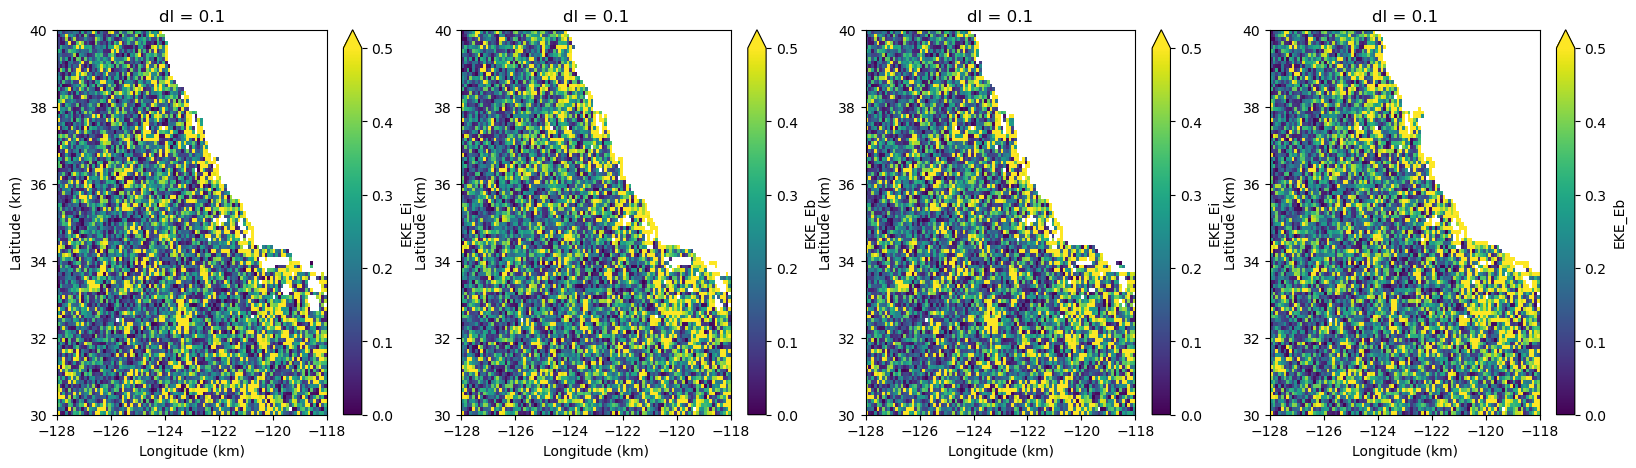

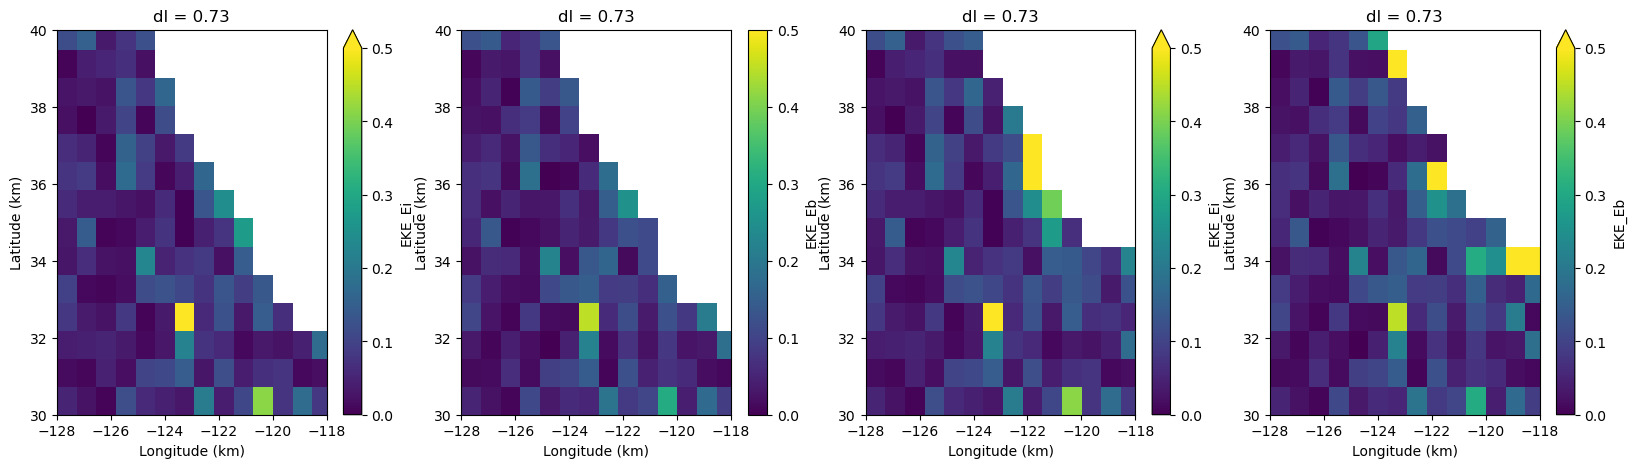

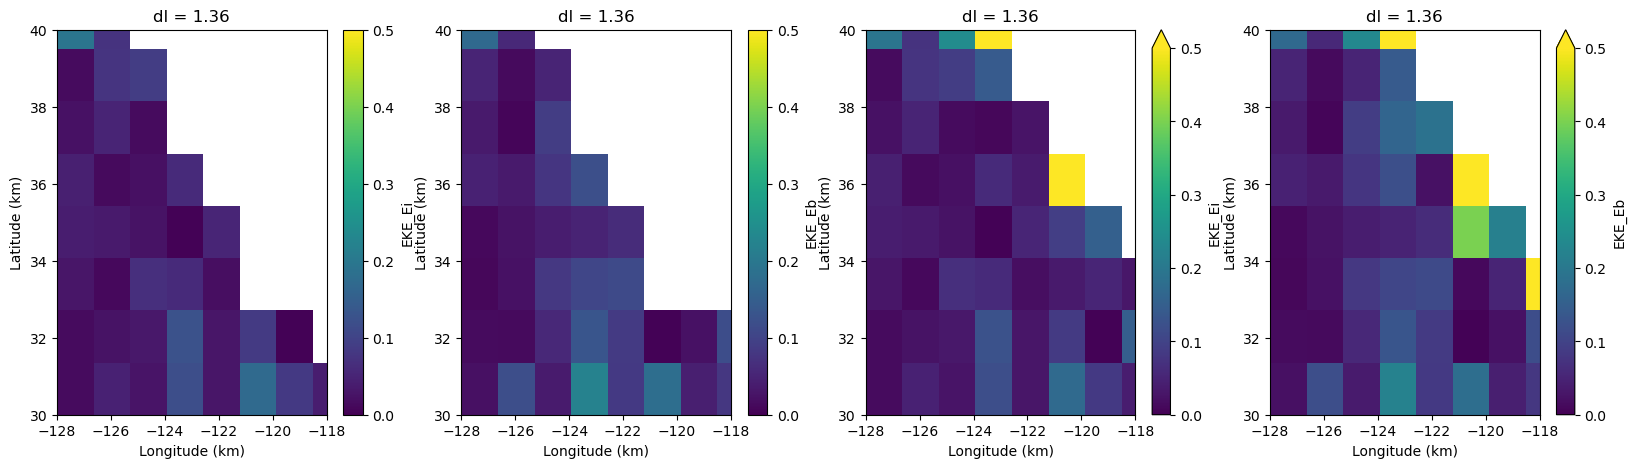

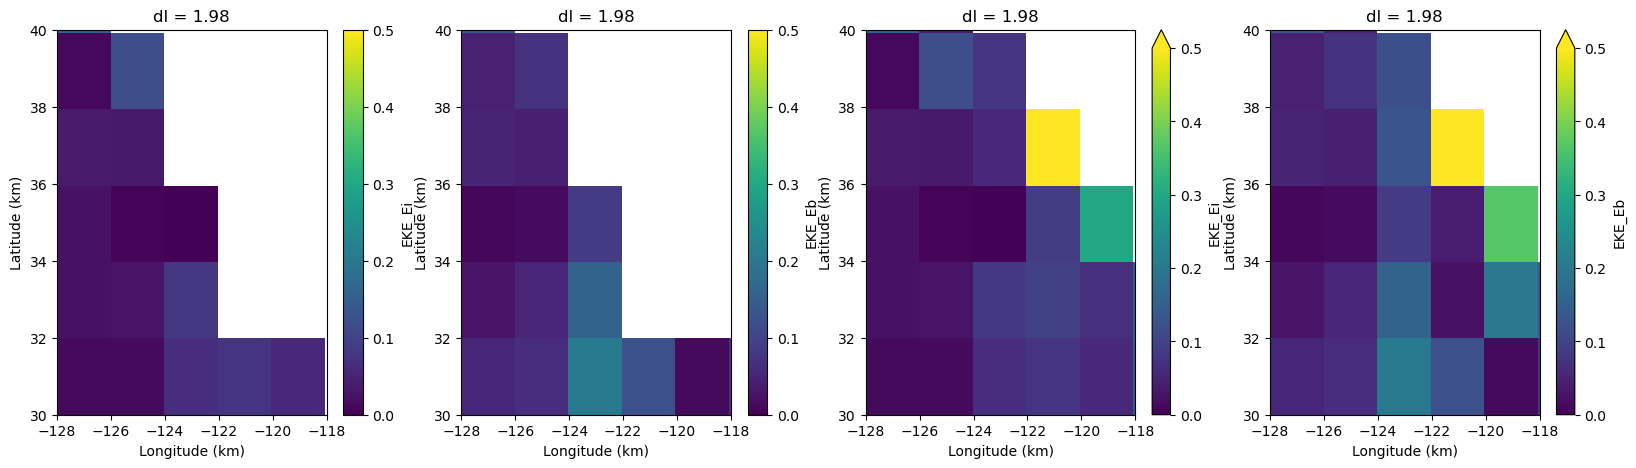

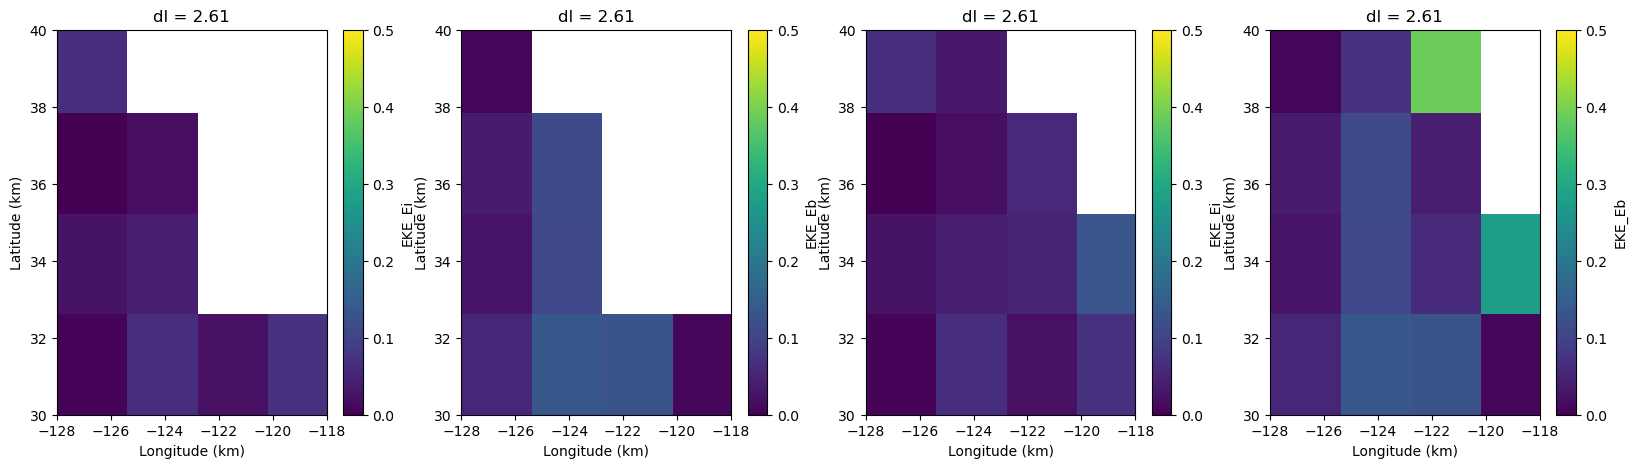

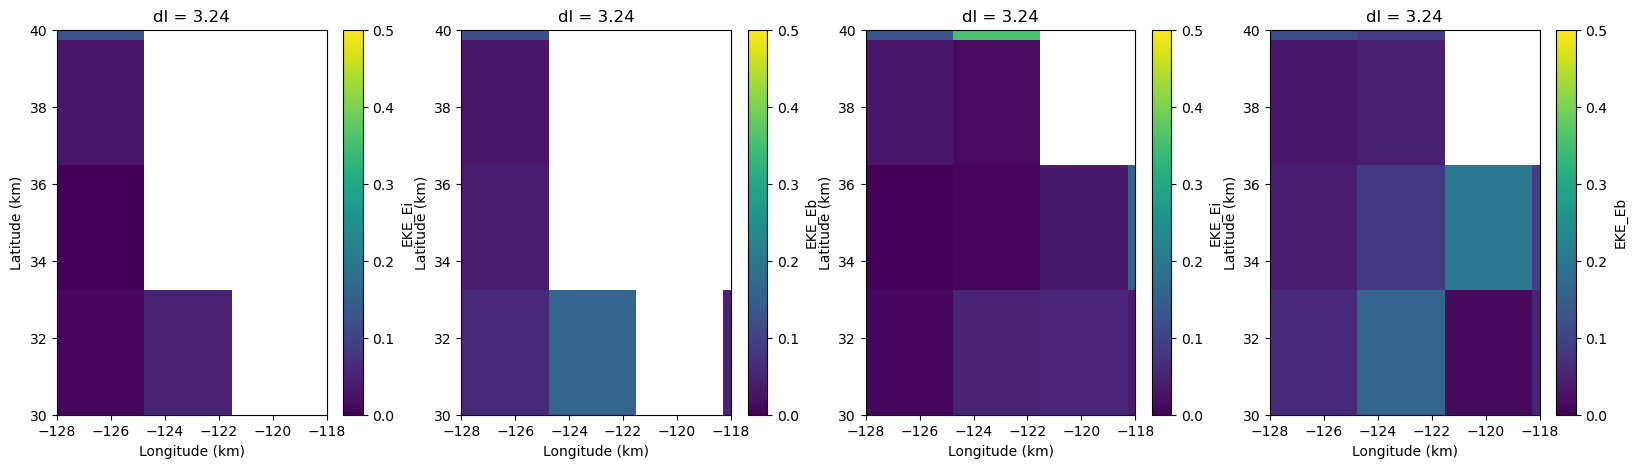

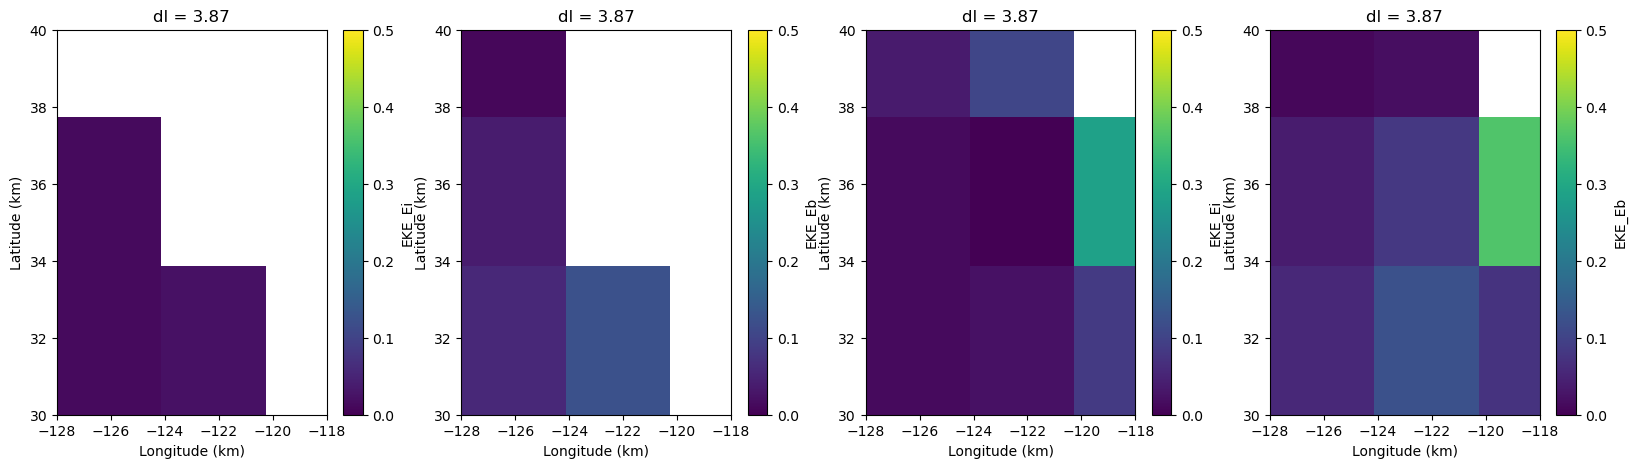

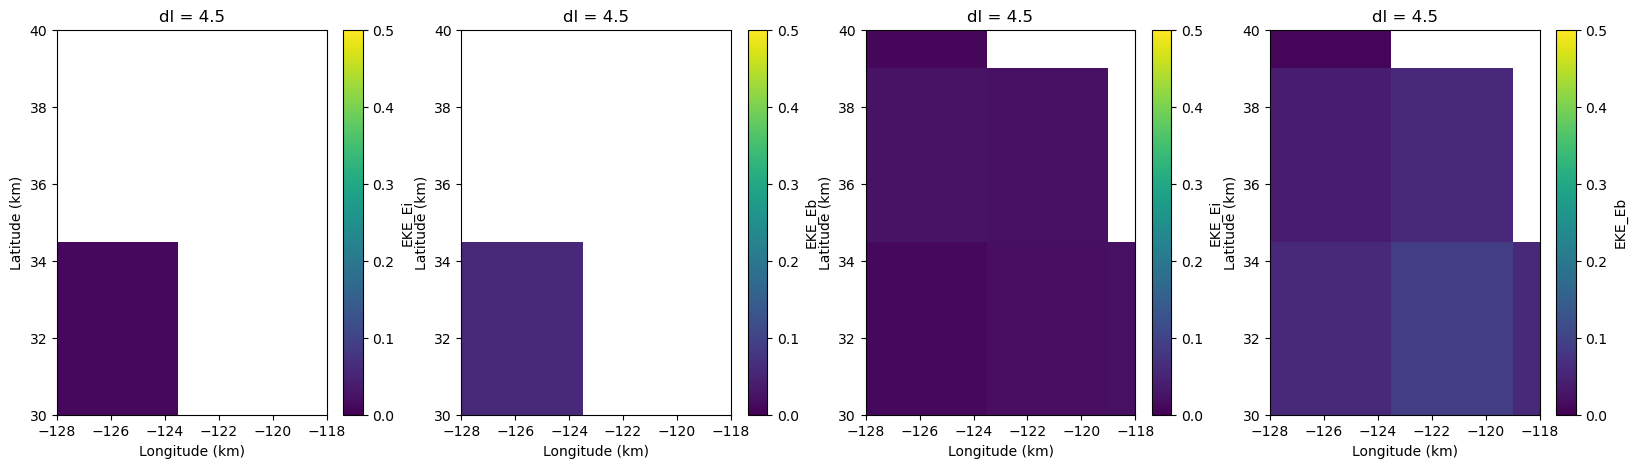

In [165]:
for i, dl in enumerate(_ds.keys()):
    if i%5==0:
        fig,ax = plt.subplots(1,4,figsize=(20,5))
        _ds[dl].EKE_Ei.plot(y='lat',ax=ax[0],vmin=0,vmax=0.5)
        _ds[dl].EKE_Eb.plot(y='lat',ax=ax[1],vmin=0,vmax=0.5)
        _ds_skipna[dl].EKE_Ei.plot(y='lat',ax=ax[2],vmin=0,vmax=0.5)
        _ds_skipna[dl].EKE_Eb.plot(y='lat',ax=ax[3],vmin=0,vmax=0.5)
        for a in ax:
            a.set_ylabel('Latitude (km)');a.set_xlabel('Longitude (km)')
            a.set_xlim(bbox[0],bbox[1]);a.set_ylim(bbox[2],bbox[3]);
            a.set_title("dl = %s"% np.around(float(dl),decimals=2))

In [166]:
means = {'mean_'+V: list(_ds[key][V].mean().values for key in _ds.keys()) for V in _ds['0.1'].data_vars}
means_skipna = {'mean_'+V: list(_ds_skipna[key][V].mean().values for key in _ds_skipna.keys()) for V in _ds_skipna['0.1'].data_vars}

In [167]:
var = {'var_'+V: list(_ds[key][V].var().values for key in _ds.keys()) for V in _ds['0.1'].data_vars}
var_skipna = {'var_'+V: list(_ds_skipna[key][V].var().values for key in _ds_skipna.keys()) for V in _ds_skipna['0.1'].data_vars}

In [171]:
ptp = {'ptp_'+V: list(np.ptp(_ds[key][V].values) for key in _ds.keys()) for V in _ds['0.1'].data_vars}
ptp_skipna = {'ptp_'+V: list(np.ptp(_ds_skipna[key][V].values) for key in _ds_skipna.keys()) for V in _ds_skipna['0.1'].data_vars}

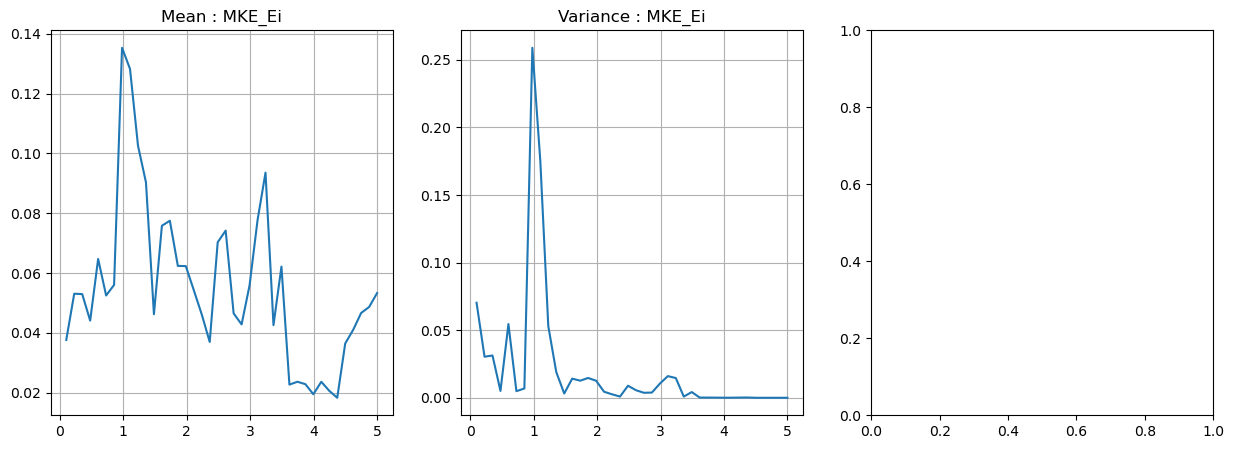

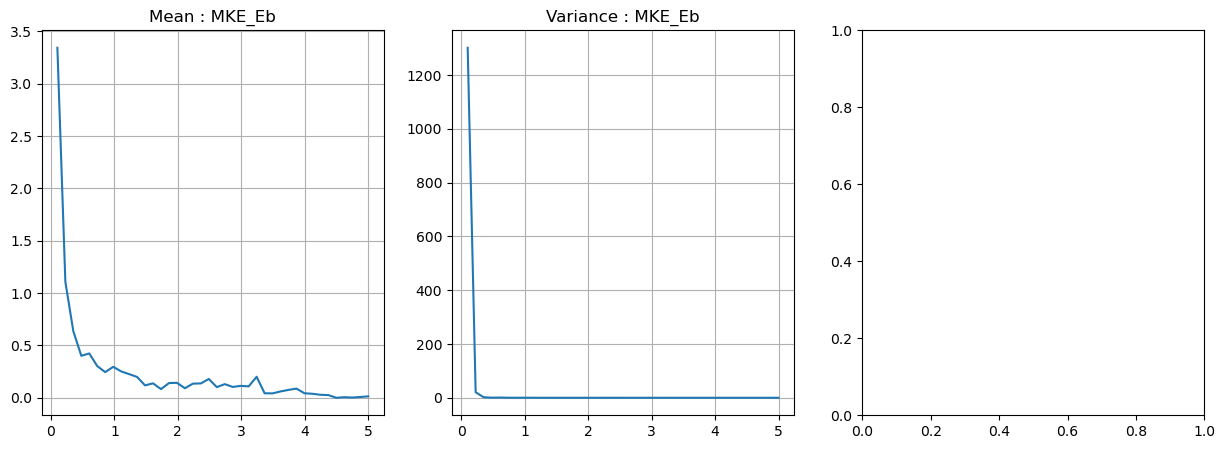

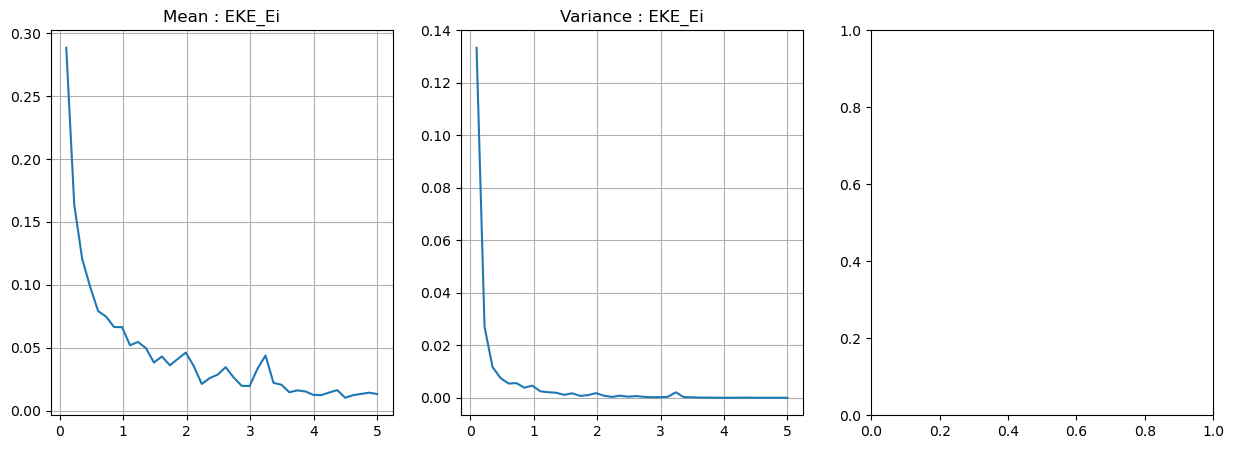

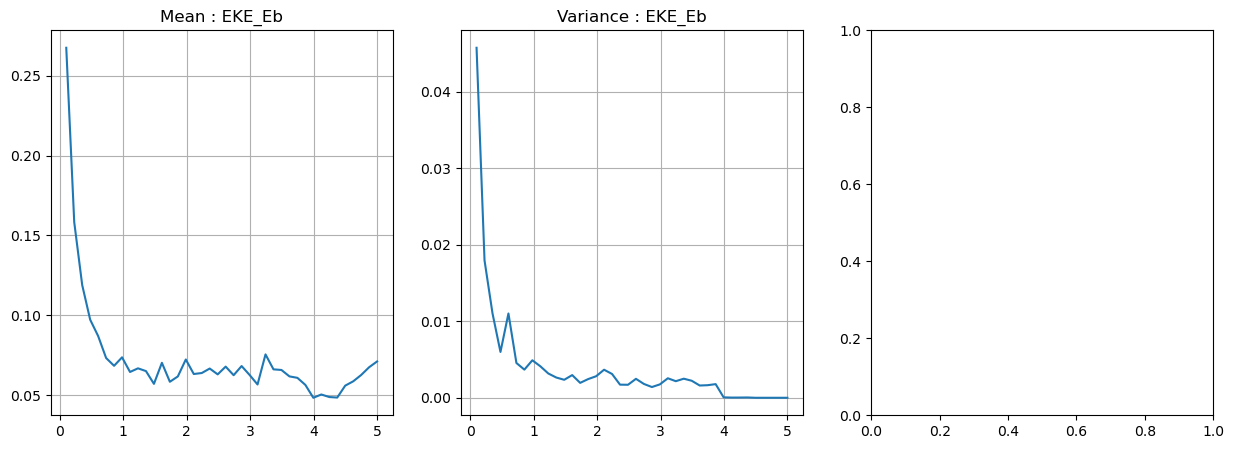

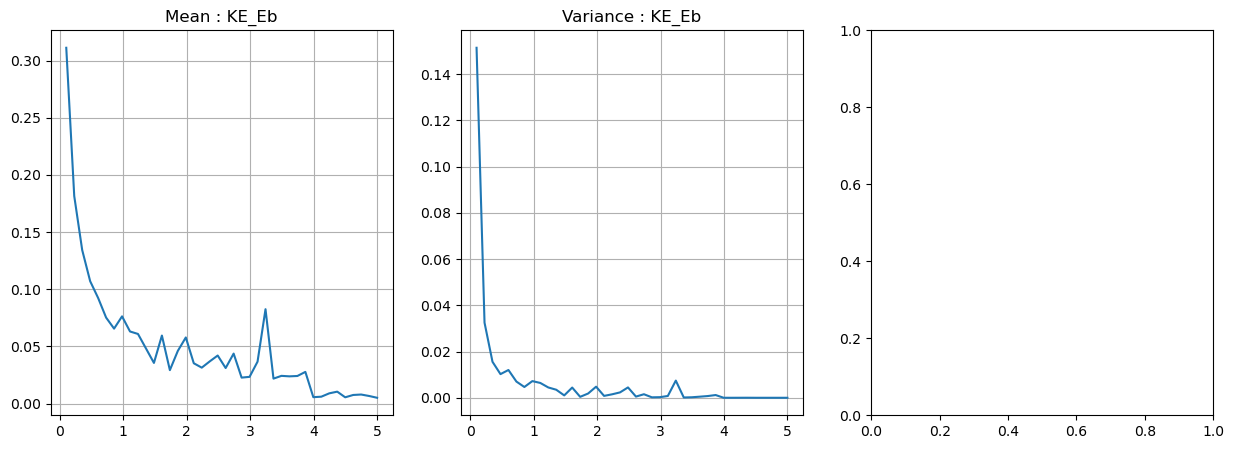

In [175]:
for key in means.keys():
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].plot(dls,means['mean_'+key.split('_')[1]+'_'+key.split('_')[2]])
    ax[1].plot(dls,var['var_'+key.split('_')[1]+'_'+key.split('_')[2]])
#    ax[2].plot(dls,ptp['ptp_'+key.split('_')[1]+'_'+key.split('_')[2]])
    ax[0].grid();ax[1].grid();
    ax[0].set_title('Mean : ' +key.split('_')[1]+'_'+key.split('_')[2])
    ax[1].set_title('Variance : ' +key.split('_')[1]+'_'+key.split('_')[2])

In [19]:
cluster.close()